# Potencial geotermoeléctrico – Barrido completo (familias `Chamber_*`)

Este notebook ejecuta un **barrido completo** sobre todos los escenarios disponibles en la estructura `Chamber_*`, calcula métricas térmicas a una profundidad fija (por defecto **2 km b.s.l.**) para umbrales térmicos (**150/180/200 °C**) y estima el **potencial volumétrico** (heat-in-place) en forma determinística (sin Monte Carlo).

## Outputs principales
- `df_all`: tabla completa por *escenario × umbral × (Lstrike,h)* con métricas térmicas y potencial.
- `summary_scenario`: resumen por *escenario × umbral* (máximos sobre geometrías).
- `sum200`, `best200_ranked`: shortlist para alta entalpía (Th=200 °C).
- Exportables: `df_all.csv`, `summary_scenario.csv`, `top_compare_200.csv`.

> Nota: Los resultados representan **potenciales teóricos** del enfoque volumétrico y deben interpretarse como órdenes de magnitud.


## 1. Imports y configuración

In [121]:
# Imports
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tu módulo con las funciones (asegurate de que pot_utils.py sea la versión corregida)
import importlib
import pot_utils as pot
importlib.reload(pot)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

## 2. Parámetros del análisis (editar acá)

In [122]:
# =========================
# PARÁMETROS A EDITAR
# =========================

# Directorio base donde viven las familias Chamber_*
BASE_DIR = Path(os.getcwd())  # <-- CAMBIAR

# Profundidad de referencia (z superficie s.n.m. en km)
SURF_Z_KM = 4.3  # <-- CAMBIAR (float). Ej: 5.0

# Timestep a evaluar
TS = 103  # <-- CAMBIAR si necesitás otro

# Profundidad bajo superficie (b.s.l.)
DEPTH_BSL_KM = 2.0

# Umbrales térmicos (°C)
TH_LIST = (150.0, 180.0, 200.0)

# Geometría para extrapolar 2D -> 3D
LSTRIKE_LIST = (10.0, 15.0, 20.0)  # km
H_LIST = (0.5, 1.0)                # km

# Flags de unidades / conversión
TEMP_IS_KELVIN = False      # En tu caso validado: False
TEMP_OFFSET = 273.15        # Para convertir de K a °C cuando TEMP_IS_KELVIN=False (tu configuración actual)
M_TO_KM = 1.0               # Si x,z ya están en km, dejar 1.0; si están en m, poner 1e-3

# Temperatura representativa dentro de intervalos T>=Th
TREP_MODE = "mean"          # "mean" (recomendado); si implementaste otros modos, podés cambiarlos

# Parámetros HIP (volumétrico)
PHI = 0.10
RHO_R = 2700
C_R = 1000
RHO_F = 1000
C_F = 4200
TREF_C = 15.0
RF = 0.15
LIFE_YEARS = 30.0

# =========================
# CHECKS mínimos
# =========================
assert SURF_Z_KM is not None, "Definí SURF_Z_KM (km s.n.m.)"
assert BASE_DIR.exists(), f"BASE_DIR no existe: {BASE_DIR}"


## 3. Descubrimiento de modelos (todas las familias `Chamber_*`)

In [123]:
model_dirs = pot.list_model_dirs_all_families(BASE_DIR)
print(f"Modelos encontrados: {len(model_dirs)}")
print("Ejemplos:")
for p in model_dirs[:]:
    print(" -", p)

Modelos encontrados: 24
Ejemplos:
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_10.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_12.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_14.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_2.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_2.5_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_4.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_6.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_8.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Pulse/Pulse_070.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Pulse/Pulse_100.0_steady-state_256x256
 - /home/jovyan/workspace/cerro_blanco/

## 4. Cálculo masivo: `df_all` (métricas + potencial)

In [124]:
dfs = []
skipped = []

for mp in model_dirs:
    try:
        df0 = pot.build_potential_table(
            MODEL_DIRS=[str(mp)],
            ts=TS,
            z_surf_km=SURF_Z_KM,
            depth_bsl_km=DEPTH_BSL_KM,
            Th_list=TH_LIST,
            Lstrike_km_list=LSTRIKE_LIST,
            h_km_list=H_LIST,
            tol_z_km=None,
            temp_is_kelvin=TEMP_IS_KELVIN,
            temp_offset=TEMP_OFFSET,
            m_to_km=M_TO_KM,
            Trep_mode=TREP_MODE
        )

        df = pot.apply_volumetric_recipe(
            df0,
            phi=PHI, rho_r=RHO_R, c_r=C_R, rho_f=RHO_F, c_f=C_F,
            Tref_C=TREF_C, Rf=RF, life_years=LIFE_YEARS
        )

        df = pot.add_pe_area_norm(df, out_col="PeA_MW_km2")  # nombre claro
        df = pot.add_metadata(df, mp)
        dfs.append(df)

    except Exception as e:
        skipped.append((str(mp), type(e).__name__, str(e)))

df_all = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
df_steady_full = df_all.copy()

print("df_all rows:", len(df_all))
print("skipped:", len(skipped))
if skipped:
    print("Primeros skips:")
    for s in skipped[:5]:
        print(" -", s)

df_all.head()

df_all rows: 432
skipped: 0


,model_dir,ts,Th_C,Lstrike_km,h_km,L_int_km,Lmax_km,Npatches,Tmean_above_C,Ares_km2,Vres_km3,Vres_m3,Pe_W,Pe_MW,PeA_MW_km2,Pe_MW_km2,Pe_W_m2,family,scenario,param_name,param_value,model_path
0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,103,150.0,10.0,0.5,30.0,30.0,1,183.218647,300.0,150.0,1.500000e+11,1.029064e+09,1029.064292,3.430214,3.430214,3.430214,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
1,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,103,150.0,10.0,1.0,30.0,30.0,1,183.218647,300.0,300.0,3.000000e+11,2.058129e+09,2058.128584,6.860429,6.860429,6.860429,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
2,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,103,150.0,15.0,0.5,30.0,30.0,1,183.218647,450.0,225.0,2.250000e+11,1.543596e+09,1543.596438,3.430214,3.430214,3.430214,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
3,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,103,150.0,15.0,1.0,30.0,30.0,1,183.218647,450.0,450.0,4.500000e+11,3.087193e+09,3087.192876,6.860429,6.860429,6.860429,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
4,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,103,150.0,20.0,0.5,30.0,30.0,1,183.218647,600.0,300.0,3.000000e+11,2.058129e+09,2058.128584,3.430214,3.430214,3.430214,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...


## 5. Resumen por escenario y umbral (steady)


In [125]:
# Resumen por escenario y umbral (máximo sobre geometrías Lstrike/h)
summary_scenario = (
    df_all.groupby(["family","scenario","param_name","param_value","Th_C"], as_index=False)
         .agg(
             L_int_km_max=("L_int_km","max"),
             Lmax_km_max=("Lmax_km","max"),
             Npatches_max=("Npatches","max"),
             Tmean_above_C_max=("Tmean_above_C","max"),
             Vres_km3_max=("Vres_km3","max"),
             Pe_MW_max=("Pe_MW","max"),
             Pe_MW_km2_max=("Pe_MW_km2","max"),  # normalizado por área (MW/km²)
         )
         .sort_values(["family","Th_C","Pe_MW_km2_max"], ascending=[True, True, False])
)

summary_scenario.head(20)

,family,scenario,param_name,param_value,Th_C,L_int_km_max,Lmax_km_max,Npatches_max,Tmean_above_C_max,Vres_km3_max,Pe_MW_max,Pe_MW_km2_max
18,Chamber_Depth,Depth_6.0_steady-state_256x256,Depth,6.0,150.0,30.0000,30.0000,1,188.325962,600.000,4451.089990,7.418483
9,Chamber_Depth,Depth_2.0_steady-state_256x256,Depth,2.0,150.0,27.8906,13.9453,2,187.363711,557.812,4078.590979,7.311766
15,Chamber_Depth,Depth_4.0_steady-state_256x256,Depth,4.0,150.0,30.0000,30.0000,1,186.489880,600.000,4329.293576,7.215489
21,Chamber_Depth,Depth_8.0_steady-state_256x256,Depth,8.0,150.0,30.0000,30.0000,1,185.904599,600.000,4290.804942,7.151342
12,Chamber_Depth,Depth_2.5_steady-state_256x256,Depth,2.5,150.0,30.0000,30.0000,1,184.930248,600.000,4227.090915,7.045152
0,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,150.0,30.0000,30.0000,1,183.218647,600.000,4116.257169,6.860429
3,Chamber_Depth,Depth_12.0_steady-state_256x256,Depth,12.0,150.0,30.0000,30.0000,1,182.231121,600.000,4052.942308,6.754904
6,Chamber_Depth,Depth_14.0_steady-state_256x256,Depth,14.0,150.0,30.0000,30.0000,1,181.773031,600.000,4023.729082,6.706215
10,Chamber_Depth,Depth_2.0_steady-state_256x256,Depth,2.0,180.0,23.2032,11.6016,2,191.856906,464.064,3627.284768,7.816346
13,Chamber_Depth,Depth_2.5_steady-state_256x256,Depth,2.5,180.0,22.9688,11.4844,2,190.841930,459.376,3537.641102,7.700971


## 6. Export de resultados


In [126]:
OUT_DIR = BASE_DIR / "outputs_potential"
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_all.to_csv(OUT_DIR / "df_all.csv", index=False)
summary_scenario.to_csv(OUT_DIR / "summary_scenario_steady.csv", index=False)

print("Exportado en:", OUT_DIR)
print(" - df_all.csv")
print(" - summary_scenario.csv")


Exportado en: /home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential
 - df_all.csv
 - summary_scenario.csv


## 7. Figura 4-1 (steady): bandas de Pe normalizado por área por familia y umbral


In [127]:
import importlib
import pot_utils as pot
importlib.reload(pot)

<module 'pot_utils' from '/home/jovyan/workspace/cerro_blanco/SETUP_B/pot_utils.py'>

## 8. Export de resultados

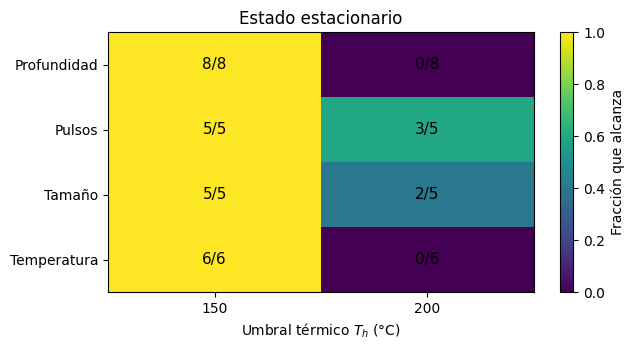

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

nr = pd.read_csv("outputs_potential/no_reach_steady_PeA.csv")

# labels lindos
order = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
label_map = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

# ---- SACAR UMBRAL 180 ----
nr = nr[nr["Th_C"] != 180].copy()

nr["family"] = pd.Categorical(nr["family"], categories=order, ordered=True)
nr = nr.sort_values(["family", "Th_C"])

# reach fraction
nr["frac_reach"] = 1.0 - nr["frac_no"]
nr["txt"] = (nr["n_total"] - nr["n_no_reach"]).astype(int).astype(str) + "/" + nr["n_total"].astype(int).astype(str)

# pivot para heatmap
mat = nr.pivot(index="family", columns="Th_C", values="frac_reach").reindex(order)
txt = nr.pivot(index="family", columns="Th_C", values="txt").reindex(order)

fig, ax = plt.subplots(figsize=(6.6, 3.6))
im = ax.imshow(mat.values, aspect="auto")  # no fijo colores a propósito

# ticks
ax.set_yticks(np.arange(len(order)))
ax.set_yticklabels([label_map[f] for f in order])
ax.set_xticks(np.arange(len(mat.columns)))
ax.set_xticklabels([f"{int(c)}" for c in mat.columns])
ax.set_xlabel(r"Umbral térmico $T_h$ (°C)")
ax.set_title("Estado estacionario")

# texto en celdas
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(j, i, txt.values[i, j], ha="center", va="center", fontsize=11)

fig.colorbar(im, ax=ax, label="Fracción que alcanza")
fig.tight_layout()

out = Path("outputs_potential/figs_resultados/Fig_steady_reach_heatmap.png")
out.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out, dpi=300)
plt.show()


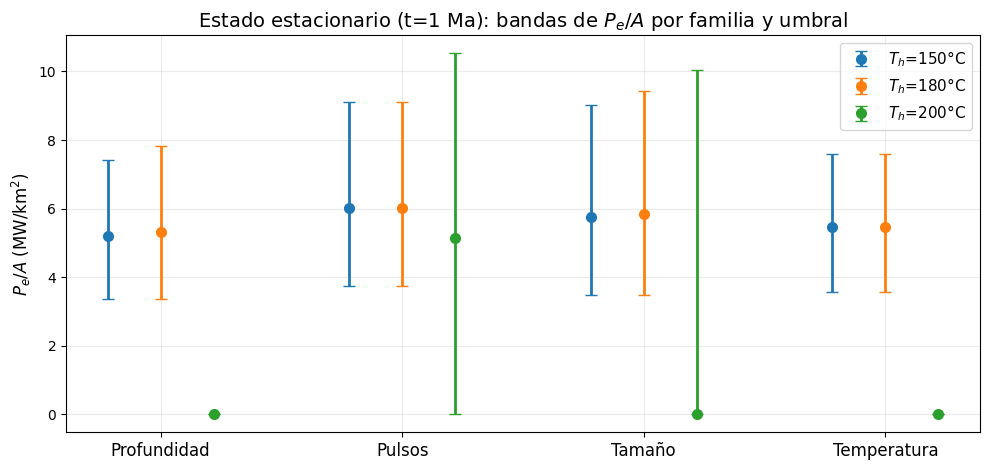

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------
# Inputs
# --------
CSV = "outputs_potential/bands_family_fmt_steady_PeA.csv"
OUTPNG = Path("outputs_potential/figs_resultados/Fig_steady_PeA_bandas_por_familia.png")
OUTPDF = Path("outputs_potential/figs_resultados/Fig_steady_PeA_bandas_por_familia.pdf")
OUTPNG.parent.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(CSV)

# Orden y nombres “lindos”
order = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
label_map = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

df["family"] = pd.Categorical(df["family"], categories=order, ordered=True)
df = df.sort_values(["family", "Th_C"])

families = [f for f in order if f in df["family"].unique()]
Ths = sorted(df["Th_C"].unique())

# --------
# Plot
# --------
x = np.arange(len(families))
width = 0.22  # separación horizontal entre Th

fig, ax = plt.subplots(figsize=(10, 4.8))

for j, Th in enumerate(Ths):
    sub = (df[df["Th_C"] == Th]
           .set_index("family")
           .reindex(families))

    y = sub["PeA_med"].to_numpy(dtype=float)
    ylow  = y - sub["PeA_min"].to_numpy(dtype=float)
    yhigh = sub["PeA_max"].to_numpy(dtype=float) - y

    xj = x + (j - (len(Ths)-1)/2) * width

    ax.errorbar(
        xj, y,
        yerr=[ylow, yhigh],
        fmt="o", capsize=4, elinewidth=2, markersize=7,
        label=fr"$T_h$={int(Th)}°C"
    )

# Estética / ejes
ax.set_xticks(x)
ax.set_xticklabels([label_map.get(f, f) for f in families], fontsize=12)

ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)", fontsize=12)
ax.set_title("Estado estacionario (t=1 Ma): bandas de $P_e/A$ por familia y umbral", fontsize=14)

ax.grid(True, alpha=0.25)
ax.legend(frameon=True, fontsize=11, loc="upper right")

# márgenes y guardado
fig.tight_layout()
fig.savefig(OUTPNG, dpi=300)
fig.savefig(OUTPDF)
plt.show()

#print("Guardado:", OUTPNG, "y", OUTPDF)


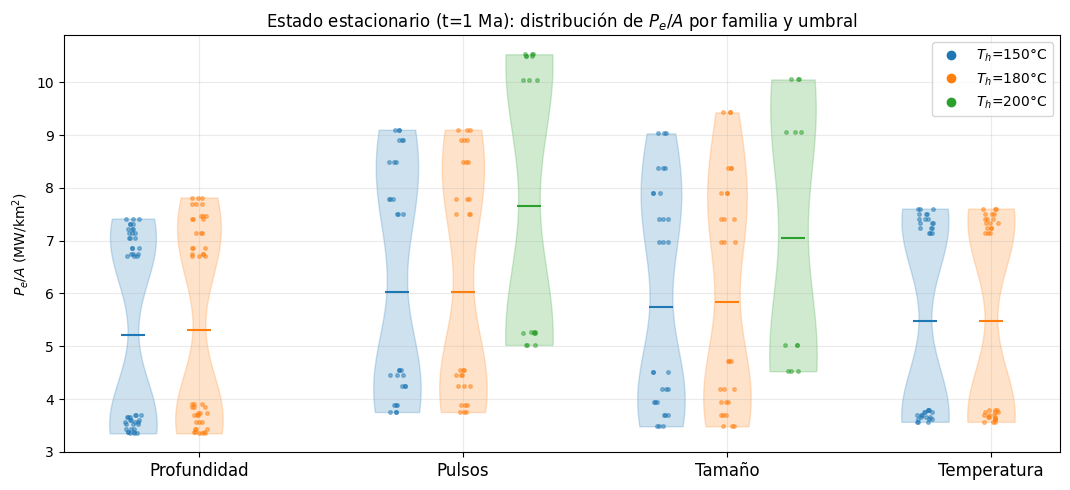

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# --------
# Inputs
# --------
CSV = "outputs_potential/df_all.csv"  # ajustá path si hace falta
OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

OUTPNG = OUT / "Fig_steady_PeA_violin_por_familia_y_Th.png"
OUTPDF = OUT / "Fig_steady_PeA_violin_por_familia_y_Th.pdf"

# --------
# Load
# --------
df = pd.read_csv(CSV)

# normalizar nombre de Pe/A
if "Pe_MW_km2" not in df.columns and "PeA_MW_km2" in df.columns:
    df["Pe_MW_km2"] = df["PeA_MW_km2"]

required = {"family","Th_C","L_int_km","Pe_MW_km2"}
missing = required - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en df_all.csv: {missing}")

# --------
# Config
# --------
order = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
label_map = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

ONLY_REACH = True  # ponelo en False si querés incluir no-reach (Pe/A ~ 0)

df["family"] = pd.Categorical(df["family"], categories=order, ordered=True)
df = df.sort_values(["family","Th_C"])

if ONLY_REACH:
    df = df[df["L_int_km"].fillna(0.0) > 0.0].copy()

families = [f for f in order if f in df["family"].astype(str).unique()]
Ths = sorted(df["Th_C"].dropna().unique())

# colores por Th
color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

# --------
# Plot (violines)
# --------
x0 = np.arange(len(families))
dx_th = 0.25

fig, ax = plt.subplots(figsize=(10.8, 5.0))

for j, Th in enumerate(Ths):
    col = color_map[Th]
    for i, fam in enumerate(families):
        vals = df[(df["family"] == fam) & (df["Th_C"] == Th)]["Pe_MW_km2"].dropna().to_numpy(dtype=float)
        if len(vals) == 0:
            continue

        pos = x0[i] + (j - (len(Ths)-1)/2)*dx_th

        vp = ax.violinplot([vals], positions=[pos], widths=0.18, showmedians=True, showextrema=False)
        for body in vp["bodies"]:
            body.set_facecolor(col)
            body.set_edgecolor(col)
            body.set_alpha(0.22)
        vp["cmedians"].set_color(col)
        vp["cmedians"].set_linewidth(1.5)

        # puntos (jitter)
        xj = pos + (np.random.rand(len(vals)) - 0.5) * 0.06
        ax.plot(xj, vals, "o", ms=2.6, color=col, alpha=0.45)

ax.set_xticks(x0)
ax.set_xticklabels([label_map.get(f, f) for f in families], fontsize=12)
ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
ttl = "Estado estacionario (t=1 Ma): distribución de $P_e/A$ por familia y umbral"
#ttl += " (solo reach)" if ONLY_REACH else " (incluye no-reach)"
ax.set_title(ttl)
ax.grid(True, alpha=0.25)

handles = [
    Line2D([0],[0], marker="o", linestyle="",
           markerfacecolor=color_map[Th], markeredgecolor=color_map[Th],
           markersize=6, label=fr"$T_h$={int(Th)}°C")
    for Th in Ths
]
ax.legend(handles=handles, loc="upper right", frameon=True)

fig.tight_layout()
fig.savefig(OUTPNG, dpi=300, bbox_inches="tight")
fig.savefig(OUTPDF, bbox_inches="tight")
plt.show()


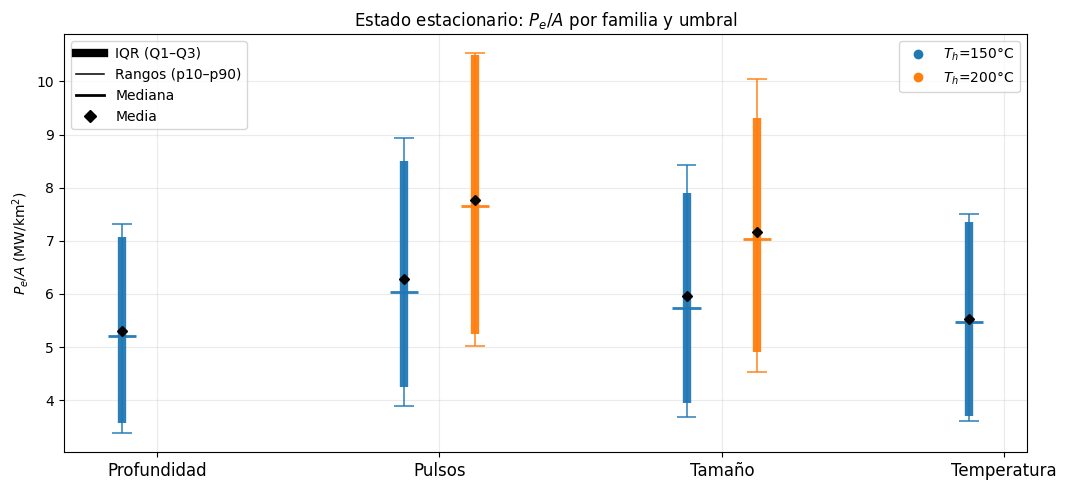

Guardado: outputs_potential/figs_resultados/Fig_steady_PeA_IQR_rangos_media_por_familia_Th150_Th200.png


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# --------
# Inputs
# --------
CSV = "outputs_potential/df_all.csv"  # ajustá path si hace falta
OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

OUTPNG = OUT / "Fig_steady_PeA_IQR_rangos_media_por_familia_Th150_Th200.png"
OUTPDF = OUT / "Fig_steady_PeA_IQR_rangos_media_por_familia_Th150_Th200.pdf"

# --------
# Load
# --------
df = pd.read_csv(CSV)

# normalizar nombre de Pe/A
if "Pe_MW_km2" not in df.columns and "PeA_MW_km2" in df.columns:
    df["Pe_MW_km2"] = df["PeA_MW_km2"]

required = {"family", "Th_C", "L_int_km", "Pe_MW_km2"}
missing = required - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en df_all.csv: {missing}")

# --------
# Config
# --------
order = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
label_map = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

ONLY_REACH = True  # ponelo en False si querés incluir no-reach (Pe/A ~ 0)

df["family"] = pd.Categorical(df["family"], categories=order, ordered=True)
df = df.sort_values(["family", "Th_C"])

if ONLY_REACH:
    df = df[df["L_int_km"].fillna(0.0) > 0.0].copy()

families = [f for f in order if f in df["family"].astype(str).unique()]

# --------
# Mantener solo Th = 150 y 200 (sin 180)
# --------
Th_keep = [150, 200]
Th_present = set(df["Th_C"].dropna().astype(int).unique())
Ths = [Th for Th in Th_keep if Th in Th_present]
if len(Ths) == 0:
    raise RuntimeError("No se encontraron Th=150 o Th=200 en el CSV.")
df = df[df["Th_C"].astype(int).isin(Ths)].copy()

# colores por Th
color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

# --------
# Helper: IQR + rangos (p10–p90) + mediana + media (sin puntos)
# --------
def draw_iqr_rangos_med_media(ax, pos, vals, col, *, rangos=(10, 90),
                              lw_rangos=1.1, lw_iqr=6.0, lw_med=2.0,
                              cap=0.035, half_med=0.05, alpha=0.95, zorder=5,
                              show_mean=True, mean_marker="D", mean_ms=5.0):
    vals = np.asarray(vals, dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return

    q1, med, q3 = np.percentile(vals, [25, 50, 75])
    p_lo, p_hi = np.percentile(vals, list(rangos))
    mean = float(np.mean(vals))

    # Rangos (p10–p90)
    ax.vlines(pos, p_lo, p_hi, color=col, linewidth=lw_rangos, alpha=alpha, zorder=zorder-1)
    ax.hlines([p_lo, p_hi], pos-cap, pos+cap, color=col, linewidth=lw_rangos, alpha=alpha, zorder=zorder-1)

    # IQR (Q1–Q3)
    ax.vlines(pos, q1, q3, color=col, linewidth=lw_iqr, alpha=alpha, zorder=zorder)

    # Mediana
    ax.hlines(med, pos-half_med, pos+half_med, color=col, linewidth=lw_med, alpha=alpha, zorder=zorder+1)

    # Media (marcador)
    if show_mean:
        ax.plot(pos, mean, marker=mean_marker, ms=mean_ms, color='k', alpha=alpha, zorder=zorder+2)

# --------
# Plot
# --------
x0 = np.arange(len(families))
dx_th = 0.25
fig, ax = plt.subplots(figsize=(10.8, 5.0))

RANGOS = (10, 90)  # cambiá a (5,95) si querés más rango

for j, Th in enumerate(Ths):
    col = color_map[Th]
    for i, fam in enumerate(families):
        vals = df[(df["family"] == fam) & (df["Th_C"].astype(int) == Th)]["Pe_MW_km2"].dropna().to_numpy(dtype=float)
        if len(vals) == 0:
            continue

        pos = x0[i] + (j - (len(Ths)-1)/2) * dx_th

        # estadísticos (sin violín, sin puntos)
        draw_iqr_rangos_med_media(ax, pos, vals, col, rangos=RANGOS, show_mean=True)

ax.set_xticks(x0)
ax.set_xticklabels([label_map.get(f, f) for f in families], fontsize=12)
ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
ax.set_title("Estado estacionario: $P_e/A$ por familia y umbral")
ax.grid(True, alpha=0.25)

# Leyenda Th (colores) arriba a la derecha
handles_th = [
    Line2D([0],[0], marker="o", linestyle="",
           markerfacecolor=color_map[Th], markeredgecolor=color_map[Th],
           markersize=6, label=fr"$T_h$={int(Th)}°C")
    for Th in Ths
]
leg_th = ax.legend(handles=handles_th, loc="upper right", frameon=True)
ax.add_artist(leg_th)

# Leyenda estadísticos arriba a la izquierda (RANGOS traducido)
handles_stats = [
    Line2D([0],[0], color="k", lw=6, label="IQR (Q1–Q3)"),
    Line2D([0],[0], color="k", lw=1.1, label=f"Rangos (p{RANGOS[0]}–p{RANGOS[1]})"),
    Line2D([0],[0], color="k", lw=2.0, label="Mediana"),
    Line2D([0],[0], marker="D", linestyle="", color="k", markersize=6, label="Media"),
]
ax.legend(handles=handles_stats, loc="upper left", frameon=True, fontsize=10)

fig.tight_layout()
fig.savefig(OUTPNG, dpi=300, bbox_inches="tight")
fig.savefig(OUTPDF, bbox_inches="tight")
plt.show()

print("Guardado:", OUTPNG)


In [131]:
OUTPNG

PosixPath('outputs_potential/figs_resultados/Fig_steady_PeA_violin_por_familia_y_Th.png')

/tmp/ipykernel_12947/742536521.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)


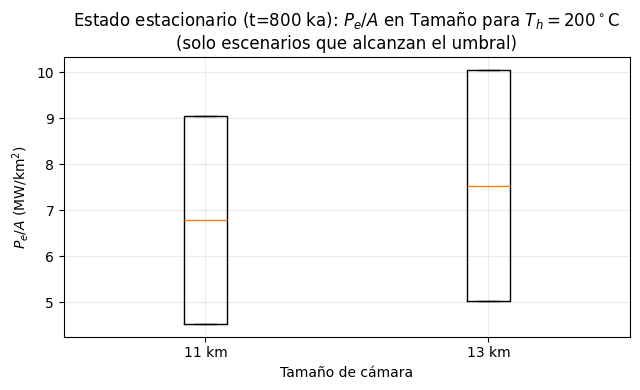

Guardado: outputs_potential/figs_resultados/Fig_steady_Tamano_Th200_PeA_boxplot_reach_only.png


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

LABEL_MAP = {
    "R_3": "5 km",
    "R_4": "7 km",
    "R_5": "9 km",
    "R_6": "11 km",
    "R_7": "13 km",
}

OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

df = pd.read_csv("outputs_potential/df_all_with_PeA.csv")

# -------------------------
# 1) Filtrar: Chamber_Radius, Th=200
# -------------------------
d = df[(df["family"] == "Chamber_Radius") & (df["Th_C"] == 200.0)].copy()

# Extraer clave R_* desde scenario (ej: "R_6_steady-state_256x256")
d["R_key"] = d["scenario"].astype(str).str.extract(r"(R_\d+)", expand=False)

# -------------------------
# 2) Identificar "reach": L_int_km > 0 a nivel escenario
# -------------------------
# (más estable que usar PeA>0)
reach_scenarios = (
    d.groupby("scenario")["L_int_km"]
     .max()
     .reset_index()
     .query("L_int_km > 0")["scenario"]
     .tolist()
)

d = d[d["scenario"].isin(reach_scenarios)].copy()

# Si por algún motivo no queda nada, mostramos diagnóstico
if d.empty:
    raise RuntimeError(
        "No quedaron escenarios que alcancen 200°C en Chamber_Radius. "
        "Chequeá que L_int_km exista y que el filtro Th_C==200.0 esté bien."
    )

# -------------------------
# 3) Orden y labels
# -------------------------
# Ordenar por R numérico
d["R_num"] = d["R_key"].str.extract(r"R_(\d+)").astype(float)
scenario_order = (
    d[["scenario","R_num","R_key"]].drop_duplicates().sort_values("R_num")["scenario"].tolist()
)

labels = []
data = []
for s in scenario_order:
    rkey = d.loc[d["scenario"] == s, "R_key"].iloc[0]
    lab = LABEL_MAP.get(rkey, rkey)
    labels.append(lab)
    data.append(d.loc[d["scenario"] == s, "PeA_MW_km2"].to_numpy(dtype=float))

# -------------------------
# 4) Plot
# -------------------------
fig, ax = plt.subplots(figsize=(6.5, 4.0))
ax.boxplot(data, labels=labels, showfliers=False)

ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
ax.set_xlabel("Tamaño de cámara")
ax.set_title(r"Estado estacionario (t=800 ka): $P_e/A$ en Tamaño para $T_h=200^\circ$C" "\n"
             r"(solo escenarios que alcanzan el umbral)")
ax.grid(True, alpha=0.25)

fig.tight_layout()
fig.savefig(OUT / "Fig_steady_Tamano_Th200_PeA_boxplot_reach_only.png", dpi=300)
fig.savefig(OUT / "Fig_steady_Tamano_Th200_PeA_boxplot_reach_only.pdf")
plt.show()

print("Guardado:", OUT / "Fig_steady_Tamano_Th200_PeA_boxplot_reach_only.png")


/tmp/ipykernel_12947/1483785490.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)
/tmp/ipykernel_12947/1483785490.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)


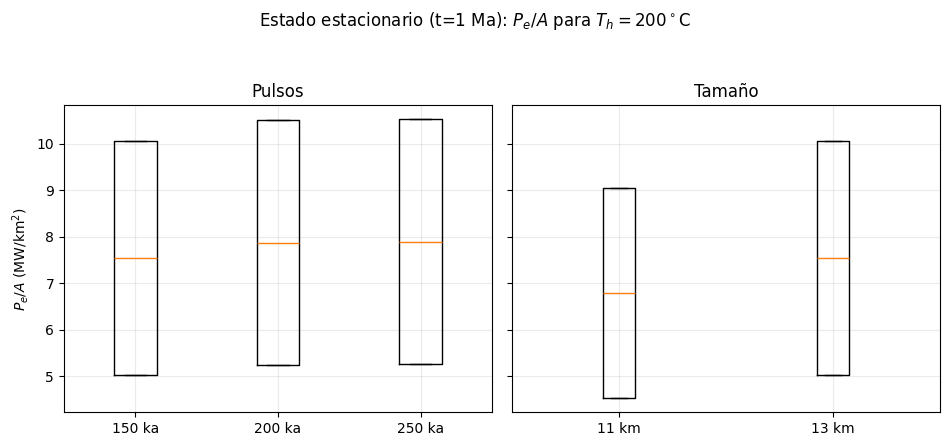

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------
# Config
# -------------------------
LABEL_MAP_RADIUS = {
    "R_3": "5 km",
    "R_4": "7 km",
    "R_5": "9 km",
    "R_6": "11 km",
    "R_7": "13 km",
}

FAMILY_LABEL = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

STEADY_TXT = "t=1 Ma"   # ajustá si querés otro texto

OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

df = pd.read_csv("outputs_potential/df_all_with_PeA.csv")

# -------------------------
# 1) Filtrar umbral
# -------------------------
d = df[df["Th_C"] == 200.0].copy()

# Columnas esperadas
required = {"family","scenario","L_int_km","PeA_MW_km2"}
missing = required - set(d.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en df_all_with_PeA.csv: {missing}")

# -------------------------
# 2) Identificar "reach": L_int_km_max > 0 por (family, scenario)
# -------------------------
reach = (
    d.groupby(["family","scenario"])["L_int_km"]
     .max()
     .reset_index()
     .query("L_int_km > 0")
)

# Filtrar sólo los reach
d = d.merge(reach[["family","scenario"]], on=["family","scenario"], how="inner").copy()

if d.empty:
    raise RuntimeError(
        "No quedaron escenarios reach para Th=200°C. "
        "Chequeá que L_int_km esté bien calculado y que Th_C==200.0 exista."
    )

# -------------------------
# 3) Función de etiqueta por escenario (solo número + unidad)
#    Usa param_value si existe; si no, intenta parsear del nombre del scenario.
# -------------------------
has_param = ("param_value" in d.columns)

def _fmt(v):
    if pd.isna(v):
        return ""
    v = float(v)
    if abs(v - round(v)) < 1e-9:
        return str(int(round(v)))
    return f"{v:.1f}"

def scenario_label(fam, scen, pval=np.nan):
    fam = str(fam)
    scen = str(scen)

    # Tamaño: map R_#
    if fam == "Chamber_Radius":
        rkey = pd.Series([scen]).str.extract(r"(R_\d+)")[0].iloc[0]
        return LABEL_MAP_RADIUS.get(rkey, rkey if isinstance(rkey, str) else scen)

    # Si hay param_value, usarlo
    if not pd.isna(pval):
        if fam == "Chamber_Depth":
            return f"{_fmt(abs(float(pval)))} km"
        if fam == "Chamber_Pulse":
            return f"{_fmt(float(pval))} ka"
        if fam == "Chamber_Temp":
            return f"{_fmt(float(pval))} °C"
        return _fmt(float(pval))

    # Fallback: extraer número del scenario
    num = pd.to_numeric(pd.Series([scen]).str.extract(r"(-?\d+\.?\d*)")[0], errors="coerce").iloc[0]
    if pd.isna(num):
        return scen

    if fam == "Chamber_Depth":
        return f"{_fmt(abs(float(num)))} km"
    if fam == "Chamber_Pulse":
        return f"{_fmt(float(num))} ka"
    if fam == "Chamber_Temp":
        return f"{_fmt(float(num))} °C"
    return _fmt(float(num))

# -------------------------
# 4) Preparar datos por familia -> lista de escenarios reach ordenados
# -------------------------
families = sorted(d["family"].unique(), key=lambda x: list(FAMILY_LABEL.keys()).index(x) if x in FAMILY_LABEL else 999)

# Si querés forzar orden:
# families = [f for f in ["Chamber_Depth","Chamber_Pulse","Chamber_Radius","Chamber_Temp"] if f in d["family"].unique()]

fam_blocks = []
for fam in families:
    dd = d[d["family"] == fam].copy()

    # Orden: por param_value si existe, si no por label
    if has_param:
        dd["param_value_num"] = pd.to_numeric(dd["param_value"], errors="coerce")
        order = (
            dd[["scenario","param_value_num"]].drop_duplicates()
              .sort_values("param_value_num")["scenario"].tolist()
        )
        # Si param_value es NaN en algunos, los manda al final; ok.
    else:
        order = sorted(dd["scenario"].unique())

    labels = []
    data = []
    for scen in order:
        sub = dd[dd["scenario"] == scen]
        pval = sub["param_value"].iloc[0] if has_param else np.nan
        lab = scenario_label(fam, scen, pval)
        vals = sub["PeA_MW_km2"].to_numpy(dtype=float)

        # evitar boxes vacías
        if np.isfinite(vals).any():
            labels.append(lab)
            data.append(vals)

    if len(data) > 0:
        fam_blocks.append((fam, labels, data))

if not fam_blocks:
    raise RuntimeError("No hay datos ploteables (PeA_MW_km2) luego del filtrado reach.")

# -------------------------
# 5) Plot multipanel (un panel por familia con reach)
# -------------------------
n = len(fam_blocks)
fig, axes = plt.subplots(
    nrows=1, ncols=n,
    figsize=(4.8*n, 4.2),
    sharey=True
)
if n == 1:
    axes = [axes]

for ax, (fam, labels, data) in zip(axes, fam_blocks):
    ax.boxplot(data, labels=labels, showfliers=False)
    ax.set_title(FAMILY_LABEL.get(fam, fam))
    ax.grid(True, alpha=0.25)
    ax.tick_params(axis="x", rotation=0)

axes[0].set_ylabel(r"$P_e/A$ (MW/km$^2$)")
fig.suptitle(
    rf"Estado estacionario ({STEADY_TXT}): $P_e/A$ para $T_h=200^\circ$C",
    y=1.05
)

fig.tight_layout()

png = OUT / "Fig_steady_Th200_PeA_boxplots_todas_las_familias_reach.png"
pdf = OUT / "Fig_steady_Th200_PeA_boxplots_todas_las_familias_reach.pdf"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(pdf, bbox_inches="tight")
plt.show()

#print("Guardado:", png)


In [134]:
import pandas as pd

summary = pd.read_csv("outputs_potential/summary_scenario_steady.csv")

tab200 = summary[(summary["Th_C"] == 200.0) & (summary["L_int_km_max"] > 0)].copy()

cols = [c for c in [
    "family","scenario","param_name","param_value",
    "L_int_km_max","Npatches_max","Tmean_above_C_max","Pe_MW_max","Pe_MW_km2_max"
] if c in tab200.columns]

tab200 = tab200[cols].sort_values(["family","param_value"])
tab200.to_csv("outputs_potential/steady_cases_reach_200C.csv", index=False)

tab200


,family,scenario,param_name,param_value,L_int_km_max,Npatches_max,Tmean_above_C_max,Pe_MW_max,Pe_MW_km2_max
36,Chamber_Pulse,Pulse_150.0_steady-state_256x256,Pulse,150.0,9.8438,1,210.270191,1978.758196,10.050784
35,Chamber_Pulse,Pulse_200.0_steady-state_256x256,Pulse,200.0,12.6562,1,213.762888,2659.029843,10.504851
34,Chamber_Pulse,Pulse_250.0_steady-state_256x256,Pulse,250.0,14.2968,1,213.941241,3010.418887,10.528296
50,Chamber_Radius,R_6_steady-state_256x256,R,6.0,16.1718,2,202.363711,2929.850269,9.058516
49,Chamber_Radius,R_7_steady-state_256x256,R,7.0,19.9218,2,210.273606,4004.769286,10.051223


In [135]:
import pandas as pd
import numpy as np

s = pd.read_csv("outputs_potential/summary_scenario_steady.csv")

# ---- helper: elegir columnas disponibles ----
def pick_col(df, candidates, label):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No encontré columna para {label}. Probé: {candidates}. Disponibles: {sorted(df.columns)}")

pe_col = pick_col(s, ["Pe_MW_km2_max", "Pe_MW_km2_max", "Pe_MW_km2", "PeA_MW_km2", "Pe_MW_max"], "Pe (norm)")
tmean_col = pick_col(s, ["Tmean_above_C_max", "Tmean_above_C", "Tmean_C_max", "Tmean_C", "Tmean"], "Tmean")
lint_col  = pick_col(s, ["L_int_km_max", "L_int_km", "L_int_max"], "L_int")

# reach (si no la tenés ya)
s["reach"] = s[lint_col].fillna(0.0) > 0.0

# si 'family_lbl' no existe, lo creamos (o lo sacás del groupby)
if "family_lbl" not in s.columns:
    FAMILY_LABEL = {
        "Chamber_Depth":  "Profundidad",
        "Chamber_Pulse":  "Pulsos",
        "Chamber_Radius": "Tamaño",
        "Chamber_Temp":   "Temperatura",
    }
    s["family_lbl"] = s["family"].map(FAMILY_LABEL).fillna(s["family"])

def top1_group(g):
    g = g.copy()
    if g["reach"].any():
        g = g[g["reach"]]
    # Orden: PeA desc, luego Tmean desc, luego L_int desc
    # (si alguna de estas no existe, ya lo habríamos cortado arriba con pick_col)
    g = g.sort_values(["Pe_MW_km2_max","Tmean_above_C_max","L_int_km_max"], ascending=False)
    return g.head(1)

top1 = (
    s.groupby(["family", "family_lbl", "Th_C"], as_index=False, group_keys=False)
     .apply(top1_group)
)

top1


/tmp/ipykernel_12947/3476273198.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(top1_group)


,family,scenario,param_name,param_value,Th_C,L_int_km_max,Lmax_km_max,Npatches_max,Tmean_above_C_max,Vres_km3_max,Pe_MW_max,Pe_MW_km2_max,reach,family_lbl
0,Chamber_Depth,Depth_6.0_steady-state_256x256,Depth,6.0,150.0,30.0000,30.0000,1,188.325962,600.000,4451.089990,7.418483,True,Profundidad
8,Chamber_Depth,Depth_2.0_steady-state_256x256,Depth,2.0,180.0,23.2032,11.6016,2,191.856906,464.064,3627.284768,7.816346,True,Profundidad
16,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,200.0,0.0000,0.0000,0,NaN,0.000,0.000000,0.000000,False,Profundidad
24,Chamber_Pulse,Pulse_250.0_steady-state_256x256,Pulse,250.0,150.0,30.0000,30.0000,1,202.702938,600.000,5460.045136,9.100075,True,Pulsos
29,Chamber_Pulse,Pulse_250.0_steady-state_256x256,Pulse,250.0,180.0,30.0000,30.0000,1,202.702938,600.000,5460.045136,9.100075,True,Pulsos
34,Chamber_Pulse,Pulse_250.0_steady-state_256x256,Pulse,250.0,200.0,14.2968,14.2968,1,213.941241,285.936,3010.418887,10.528296,True,Pulsos
39,Chamber_Radius,R_7_steady-state_256x256,R,7.0,150.0,30.0000,30.0000,1,202.139693,600.000,5418.672896,9.031121,True,Tamaño
44,Chamber_Radius,R_7_steady-state_256x256,R,7.0,180.0,26.4844,13.2422,2,205.352906,529.688,4993.821351,9.427854,True,Tamaño
49,Chamber_Radius,R_7_steady-state_256x256,R,7.0,200.0,19.9218,9.9609,2,210.273606,398.436,4004.769286,10.051223,True,Tamaño
54,Chamber_Temp,Temp_950_steady-state_256x256,Temp,950.0,150.0,30.0000,30.0000,1,190.004229,600.000,4563.816024,7.606360,True,Temperatura


In [136]:
# TOP-3 por familia y umbral
def topk_group(g, k=3):
    g = g.copy()
    if g["reach"].any():
        g = g[g["reach"]]
    g = g.sort_values(["Pe_MW_km2_max","Tmean_above_C_max","L_int_km_max"], ascending=False)
    return g.head(k)

top3 = (
    s.groupby(["family","family_lbl","Th_C"], as_index=False, group_keys=False)
     .apply(lambda g: topk_group(g, k=3))
)

top3["rank"] = top3.groupby(["family_lbl","Th_C"]).cumcount() + 1
top3["status"] = np.where(top3["reach"], "reach", "NR")

cols3 = [
    "family_lbl","Th_C","rank","status",
    "scenario","param_value",
    "Pe_MW_km2_max","Tmean_above_C_max","L_int_km_max","Npatches_max",
]
cols3 = [c for c in cols3 if c in top3.columns]
top3_out = top3[cols3].sort_values(["family_lbl","Th_C","rank"])

top3_out.to_csv("outputs_potential/top3_by_family_Th_steady.csv", index=False)
top3_out


/tmp/ipykernel_12947/2105722249.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: topk_group(g, k=3))


,family_lbl,Th_C,rank,status,scenario,param_value,Pe_MW_km2_max,Tmean_above_C_max,L_int_km_max,Npatches_max
0,Profundidad,150.0,1,reach,Depth_6.0_steady-state_256x256,6.0,7.418483,188.325962,30.0000,1
1,Profundidad,150.0,2,reach,Depth_2.0_steady-state_256x256,2.0,7.311766,187.363711,27.8906,2
2,Profundidad,150.0,3,reach,Depth_4.0_steady-state_256x256,4.0,7.215489,186.489880,30.0000,1
8,Profundidad,180.0,1,reach,Depth_2.0_steady-state_256x256,2.0,7.816346,191.856906,23.2032,2
9,Profundidad,180.0,2,reach,Depth_2.5_steady-state_256x256,2.5,7.700971,190.841930,22.9688,2
10,Profundidad,180.0,3,reach,Depth_4.0_steady-state_256x256,4.0,7.470484,188.792473,24.4922,2
16,Profundidad,200.0,1,NR,Depth_10.0_steady-state_256x256,10.0,0.000000,NaN,0.0000,0
17,Profundidad,200.0,2,NR,Depth_12.0_steady-state_256x256,12.0,0.000000,NaN,0.0000,0
18,Profundidad,200.0,3,NR,Depth_14.0_steady-state_256x256,14.0,0.000000,NaN,0.0000,0
24,Pulsos,150.0,1,reach,Pulse_250.0_steady-state_256x256,250.0,9.100075,202.702938,30.0000,1


/tmp/ipykernel_14772/2842156510.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s.groupby(["family","Th_C"], as_index=False, group_keys=False)
/tmp/ipykernel_14772/2842156510.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(topk)
/tmp/ipykernel_14772/2842156510.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

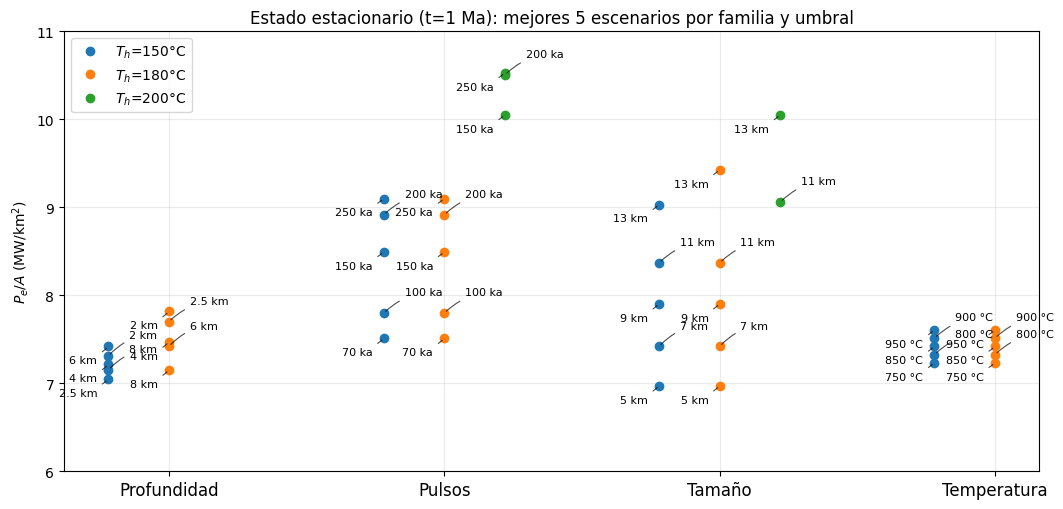

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

TOPK = 5

FAMILY_ORDER = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
FAMILY_LABEL = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

LABEL_MAP_RADIUS = {
    "R_3": "5 km",
    "R_4": "7 km",
    "R_5": "9 km",
    "R_6": "11 km",
    "R_7": "13 km",
}

OUTDIR = Path("outputs_potential/figs_resultados")
OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Load
# -------------------------
s = pd.read_csv("outputs_potential/summary_scenario_steady.csv")

for c in ["Th_C","Pe_MW_km2_max","L_int_km_max","Tmean_above_C_max","param_value"]:
    if c in s.columns:
        s[c] = pd.to_numeric(s[c], errors="coerce")

# Reach only
s = s[s["L_int_km_max"].fillna(0.0) > 0.0].copy()

# Order families
s["family"] = pd.Categorical(s["family"], categories=FAMILY_ORDER, ordered=True)

def topk(g, k=TOPK):
    g = g.sort_values(["Pe_MW_km2_max","Tmean_above_C_max","L_int_km_max"], ascending=False)
    return g.head(k)

top = (
    s.groupby(["family","Th_C"], as_index=False, group_keys=False)
     .apply(topk)
).copy()
top["rank"] = top.groupby(["family","Th_C"]).cumcount() + 1

# -------------------------
# Labels: solo número + unidad
# -------------------------
def fmt_number(v):
    """Formato corto: sin decimales si es entero; si no, 1 decimal."""
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return None
    if abs(v - round(v)) < 1e-9:
        return str(int(round(v)))
    return f"{v:.1f}"

def label_only_units(row):
    fam = str(row["family"])
    pval = row.get("param_value", np.nan)

    # Tamaño: mapear R_# -> "X km"
    if fam == "Chamber_Radius":
        base = str(row["scenario"]).split("_steady")[0]  # ej: R_6
        return LABEL_MAP_RADIUS.get(base, base)

    # Si no hay param_value, intentamos parsear algo del nombre
    if pd.isna(pval):
        # intenta extraer número del scenario
        # ej: Depth_-10.0..., Pulse_150..., Temp_750...
        scen = str(row["scenario"])
        num = pd.to_numeric(pd.Series(scen).str.extract(r"(-?\d+\.?\d*)")[0], errors="coerce").iloc[0]
        pval = num

    if pd.isna(pval):
        return ""  # último fallback

    if fam == "Chamber_Depth":
        return f"{fmt_number(abs(float(pval)))} km"
    if fam == "Chamber_Pulse":
        return f"{fmt_number(float(pval))} ka"
    if fam == "Chamber_Temp":
        return f"{fmt_number(float(pval))} °C"

    # fallback genérico si apareciera otra familia
    return f"{fmt_number(float(pval))}"

top["label"] = top.apply(label_only_units, axis=1)

# -------------------------
# Plot
# -------------------------
families = [f for f in FAMILY_ORDER if f in top["family"].astype(str).unique()]
Ths = sorted(top["Th_C"].unique())

x = np.arange(len(families))
dx_th = 0.22
dx_rank =0

fig, ax = plt.subplots(figsize=(10.8, 5.2))

for j, Th in enumerate(Ths):
    sub = top[top["Th_C"] == Th].copy()
    sub["x0"] = sub["family"].apply(lambda f: families.index(str(f))).astype(float)
    sub["x"] = sub["x0"] + (j - (len(Ths)-1)/2) * dx_th + (sub["rank"] - (TOPK+1)/2) * dx_rank

    ax.plot(sub["x"], sub["Pe_MW_km2_max"], "o", label=fr"$T_h$={int(Th)}°C")

    for _, r in sub.iterrows():
        xo, yo = float(r["x"]), float(r["Pe_MW_km2_max"])
        offy = 15 if int(r["rank"]) % 2 == 0 else -10
        dx_lab = 15 if int(r["rank"]) % 2 == 0 else -8
        
        ax.annotate(
            str(r["label"]),
            (xo, yo),
            textcoords="offset points",
            xytext=(dx_lab, offy),
            ha = "left" if dx_lab > 0 else "right",
            va="center",
            fontsize=8,
            rotation=0,
            arrowprops=dict(
                arrowstyle="-",   # línea (sin punta). Usá "->" si querés flecha
                lw=0.8,
                alpha=0.7,
                shrinkA=2,    # separa la línea del texto
                shrinkB=2,    # separa la línea del punto
                connectionstyle="arc3,rad=0.15"  # curva leve
            )
        )

ax.set_xticks(x)
ax.set_xticklabels([FAMILY_LABEL[f] for f in families], fontsize=12)
ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
ax.set_title(f"Estado estacionario (t=1 Ma): mejores {TOPK} escenarios por familia y umbral")
ax.grid(True, alpha=0.25)
ax.legend(frameon=True, loc="upper left")
ax.set_ylim(6, 11)


fig.tight_layout()
png = OUTDIR / f"Fig_steady_top{TOPK}_reach_PeAmax_por_familia_y_Th_labels_units.png"
pdf = OUTDIR / f"Fig_steady_top{TOPK}_reach_PeAmax_por_familia_y_Th_labels_units.pdf"
fig.savefig(png, dpi=300)
fig.savefig(pdf)
plt.show()

#print("Guardado:", png, "y", pdf)


/tmp/ipykernel_14772/3981149888.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s.groupby(["family", "Th_C"], as_index=False, group_keys=False)
/tmp/ipykernel_14772/3981149888.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(topk)
/tmp/ipykernel_14772/3981149888.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

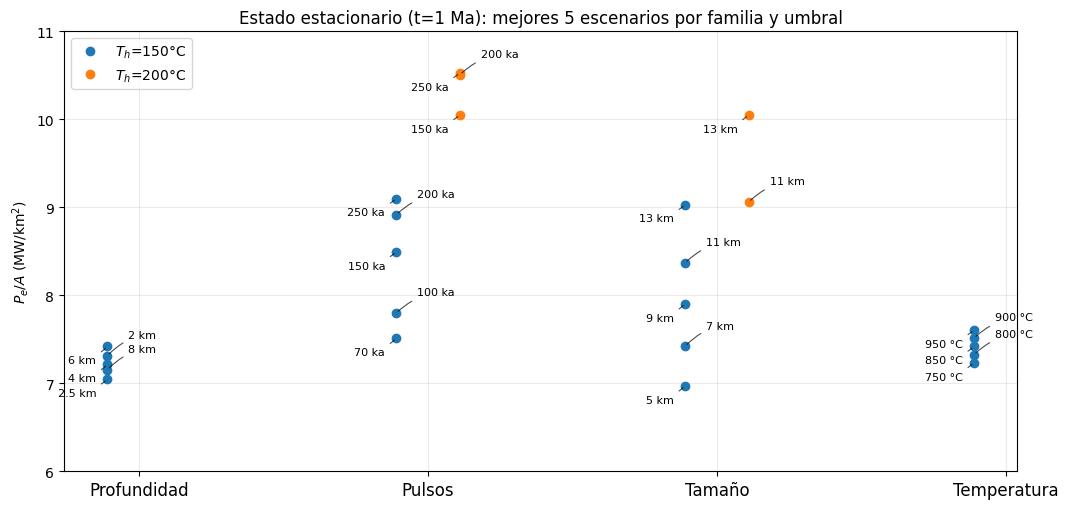

Guardado: outputs_potential/figs_resultados/Fig_steady_top5_reach_PeAmax_por_familia_Th150_Th200_labels_units.png y outputs_potential/figs_resultados/Fig_steady_top5_reach_PeAmax_por_familia_Th150_Th200_labels_units.pdf


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

TOPK = 5

FAMILY_ORDER = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
FAMILY_LABEL = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

LABEL_MAP_RADIUS = {
    "R_3": "5 km",
    "R_4": "7 km",
    "R_5": "9 km",
    "R_6": "11 km",
    "R_7": "13 km",
}

OUTDIR = Path("outputs_potential/figs_resultados")
OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Load
# -------------------------
s = pd.read_csv("outputs_potential/summary_scenario_steady.csv")

for c in ["Th_C", "Pe_MW_km2_max", "L_int_km_max", "Tmean_above_C_max", "param_value"]:
    if c in s.columns:
        s[c] = pd.to_numeric(s[c], errors="coerce")

# Reach only
s = s[s["L_int_km_max"].fillna(0.0) > 0.0].copy()

# -------------------------
# Filtrar solo Th = 150 y 200 (sin 180)
# -------------------------
TH_KEEP = [150, 200]
s = s[s["Th_C"].round().astype("Int64").isin(TH_KEEP)].copy()

# Order families
s["family"] = pd.Categorical(s["family"], categories=FAMILY_ORDER, ordered=True)

def topk(g, k=TOPK):
    g = g.sort_values(["Pe_MW_km2_max", "Tmean_above_C_max", "L_int_km_max"], ascending=False)
    return g.head(k)

top = (
    s.groupby(["family", "Th_C"], as_index=False, group_keys=False)
     .apply(topk)
).copy()
top["rank"] = top.groupby(["family", "Th_C"]).cumcount() + 1

# -------------------------
# Labels: solo número + unidad
# -------------------------
def fmt_number(v):
    """Formato corto: sin decimales si es entero; si no, 1 decimal."""
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return None
    if abs(v - round(v)) < 1e-9:
        return str(int(round(v)))
    return f"{v:.1f}"

def label_only_units(row):
    fam = str(row["family"])
    pval = row.get("param_value", np.nan)

    # Tamaño: mapear R_# -> "X km"
    if fam == "Chamber_Radius":
        base = str(row["scenario"]).split("_steady")[0]  # ej: R_6
        return LABEL_MAP_RADIUS.get(base, base)

    # Si no hay param_value, intentamos parsear algo del nombre
    if pd.isna(pval):
        scen = str(row["scenario"])
        num = pd.to_numeric(pd.Series(scen).str.extract(r"(-?\d+\.?\d*)")[0], errors="coerce").iloc[0]
        pval = num

    if pd.isna(pval):
        return ""  # último fallback

    if fam == "Chamber_Depth":
        return f"{fmt_number(abs(float(pval)))} km"
    if fam == "Chamber_Pulse":
        return f"{fmt_number(float(pval))} ka"
    if fam == "Chamber_Temp":
        return f"{fmt_number(float(pval))} °C"

    return f"{fmt_number(float(pval))}"

top["label"] = top.apply(label_only_units, axis=1)

# -------------------------
# Plot
# -------------------------
families = [f for f in FAMILY_ORDER if f in top["family"].astype(str).unique()]
Ths = sorted(top["Th_C"].dropna().unique())  # debería quedar [150, 200]

x = np.arange(len(families))
dx_th = 0.22
dx_rank = 0

fig, ax = plt.subplots(figsize=(10.8, 5.2))

for j, Th in enumerate(Ths):
    sub = top[top["Th_C"] == Th].copy()
    sub["x0"] = sub["family"].apply(lambda f: families.index(str(f))).astype(float)
    sub["x"] = sub["x0"] + (j - (len(Ths)-1)/2) * dx_th + (sub["rank"] - (TOPK+1)/2) * dx_rank

    ax.plot(sub["x"], sub["Pe_MW_km2_max"], "o", label=fr"$T_h$={int(Th)}°C")

    for _, r in sub.iterrows():
        xo, yo = float(r["x"]), float(r["Pe_MW_km2_max"])
        offy = 15 if int(r["rank"]) % 2 == 0 else -10
        dx_lab = 15 if int(r["rank"]) % 2 == 0 else -8

        ax.annotate(
            str(r["label"]),
            (xo, yo),
            textcoords="offset points",
            xytext=(dx_lab, offy),
            ha="left" if dx_lab > 0 else "right",
            va="center",
            fontsize=8,
            rotation=0,
            arrowprops=dict(
                arrowstyle="-",
                lw=0.8,
                alpha=0.7,
                shrinkA=2,
                shrinkB=2,
                connectionstyle="arc3,rad=0.15"
            )
        )

ax.set_xticks(x)
ax.set_xticklabels([FAMILY_LABEL[f] for f in families], fontsize=12)
ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
ax.set_title(f"Estado estacionario (t=1 Ma): mejores {TOPK} escenarios por familia y umbral")
ax.grid(True, alpha=0.25)
ax.legend(frameon=True, loc="upper left")
ax.set_ylim(6, 11)

fig.tight_layout()
png = OUTDIR / f"Fig_steady_top{TOPK}_reach_PeAmax_por_familia_Th150_Th200_labels_units.png"
pdf = OUTDIR / f"Fig_steady_top{TOPK}_reach_PeAmax_por_familia_Th150_Th200_labels_units.pdf"
fig.savefig(png, dpi=300)
fig.savefig(pdf)
plt.show()

print("Guardado:", png, "y", pdf)


In [138]:
import os
import importlib
import pandas as pd
import numpy as np
from pathlib import Path

# si lo pegaste en pot_utils.py:
# import pot_utils as pot
# importlib.reload(pot)

# si usás el módulo separado:
import pot_utils as pot
importlib.reload(pot)

# =========================
# PARÁMETROS PEAK (máximos)
# =========================
STEP_EVERY_PEAK = 5     # submuestreo para acelerar
TS_MIN_PEAK = None
TS_MAX_PEAK = None
SKIP = set()

PEAK_COL = "Pe_MW_km2"  # criterio de máximo (equivale a Pe/A en MW/km²)

# -------------------------
# 1) listar modelos
# -------------------------
model_dirs = pot.list_model_dirs_all_families(BASE_DIR)
print("Modelos encontrados:", len(model_dirs))

# -------------------------
# 2) calcular máximos en el tiempo
# -------------------------
df_peak_full = pot.build_peak_table_all_models(
    model_dirs=model_dirs,
    z_surf_km=SURF_Z_KM,
    depth_bsl_km=DEPTH_BSL_KM,
    Th_list=TH_LIST,
    Lstrike_km_list=LSTRIKE_LIST,
    h_km_list=H_LIST,
    step_every=STEP_EVERY_PEAK,
    ts_min=TS_MIN_PEAK,
    ts_max=TS_MAX_PEAK,
    skip=SKIP,
    phi=PHI, rho_r=RHO_R, c_r=C_R, rho_f=RHO_F, c_f=C_F,
    Tref_C=TREF_C, Rf=RF, life_years=LIFE_YEARS,
    tol_z_km=None,
    temp_is_kelvin=TEMP_IS_KELVIN,
    temp_offset=TEMP_OFFSET,
    m_to_km=M_TO_KM,
    Trep_mode=TREP_MODE,
    peak_col=PEAK_COL,
    time_unit=1.0,
    to_ka=1000.0
)

print("df_peak_full rows:", len(df_peak_full))

skipped = df_peak_full.attrs.get("skipped", [])
print("skipped:", len(skipped))
if skipped:
    print("Primeros 5 skips:")
    for s in skipped[:5]:
        print(" -", s)

df_peak_full.head()


Modelos encontrados: 24
df_peak_full rows: 432
skipped: 0


,model_dir,ts_used,Th_C,Lstrike_km,h_km,L_int_km,Lmax_km,Npatches,Tmean_above_C,Ares_km2,Vres_km3,Vres_m3,Pe_W,Pe_MW,Pe_MW_km2,PeA_MW_km2,Pe_W_m2,ts_peak,t_peak_ka,peak_of,family,scenario,param_name,param_value,model_path
0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,75,150.0,10.0,0.5,30.0,30.0,1,183.52295,300.0,150.0,1.500000e+11,1.033965e+09,1033.965151,3.446551,3.446551,3.446551,75,710.0,Pe_MW_km2,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
1,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,75,150.0,10.0,1.0,30.0,30.0,1,183.52295,300.0,300.0,3.000000e+11,2.067930e+09,2067.930302,6.893101,6.893101,6.893101,75,710.0,Pe_MW_km2,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
2,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,75,150.0,15.0,0.5,30.0,30.0,1,183.52295,450.0,225.0,2.250000e+11,1.550948e+09,1550.947727,3.446551,3.446551,3.446551,75,710.0,Pe_MW_km2,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
3,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,75,150.0,15.0,1.0,30.0,30.0,1,183.52295,450.0,450.0,4.500000e+11,3.101895e+09,3101.895454,6.893101,6.893101,6.893101,75,710.0,Pe_MW_km2,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...
4,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...,75,150.0,20.0,0.5,30.0,30.0,1,183.52295,600.0,300.0,3.000000e+11,2.067930e+09,2067.930302,3.446551,3.446551,3.446551,75,710.0,Pe_MW_km2,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,/home/jovyan/workspace/cerro_blanco/SETUP_B/Ch...


In [139]:
def summarize_peak(g):
    g = g.copy()
    # fila que maximiza Pe/A dentro de las geometrías (y ya es máximo temporal por geometría)
    i = g["Pe_MW_km2"].astype(float).idxmax()
    r = g.loc[i]

    return pd.Series({
        "ts_peak": int(r["ts_peak"]),
        "t_peak_ka": float(r["t_peak_ka"]),
        "Lstrike_km_peak": float(r["Lstrike_km"]),
        "h_km_peak": float(r["h_km"]),
        "L_int_km_peak": float(r["L_int_km"]),
        "Lmax_km_peak": float(r["Lmax_km"]),
        "Npatches_peak": int(r["Npatches"]),
        "Tmean_above_C_peak": float(r["Tmean_above_C"]),
        "Vres_km3_peak": float(r["Vres_km3"]),
        "Pe_MW_peak": float(r["Pe_MW"]),
        "Pe_MW_km2_peak": float(r["Pe_MW_km2"]),
    })

summary_scenario_peak = (
    df_peak_full
    .groupby(["family","scenario","param_name","param_value","Th_C"], as_index=False)
    .apply(summarize_peak)
    .reset_index(drop=True)
    .sort_values(["family","Th_C","Pe_MW_km2_peak"], ascending=[True, True, False])
)

summary_scenario_peak.head(20)


/tmp/ipykernel_12947/3901025204.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_peak)


,family,scenario,param_name,param_value,Th_C,ts_peak,t_peak_ka,Lstrike_km_peak,h_km_peak,L_int_km_peak,Lmax_km_peak,Npatches_peak,Tmean_above_C_peak,Vres_km3_peak,Pe_MW_peak,Pe_MW_km2_peak
9,Chamber_Depth,Depth_2.0_steady-state_256x256,Depth,2.0,150.0,10.0,60.0,10.0,1.0,30.0000,30.0000,1.0,240.593622,300.000,4278.455362,14.261518
12,Chamber_Depth,Depth_2.5_steady-state_256x256,Depth,2.5,150.0,10.0,60.0,10.0,1.0,30.0000,30.0000,1.0,227.364200,300.000,3709.483981,12.364947
15,Chamber_Depth,Depth_4.0_steady-state_256x256,Depth,4.0,150.0,20.0,160.0,10.0,1.0,30.0000,30.0000,1.0,207.503173,300.000,2909.370909,9.697903
18,Chamber_Depth,Depth_6.0_steady-state_256x256,Depth,6.0,150.0,30.0,260.0,10.0,1.0,30.0000,30.0000,1.0,196.413305,300.000,2503.294583,8.344315
21,Chamber_Depth,Depth_8.0_steady-state_256x256,Depth,8.0,150.0,50.0,460.0,10.0,1.0,30.0000,30.0000,1.0,188.035660,300.000,2215.863216,7.386211
0,Chamber_Depth,Depth_10.0_steady-state_256x256,Depth,10.0,150.0,75.0,710.0,10.0,1.0,30.0000,30.0000,1.0,183.522950,300.000,2067.930302,6.893101
3,Chamber_Depth,Depth_12.0_steady-state_256x256,Depth,12.0,150.0,95.0,910.0,10.0,1.0,30.0000,30.0000,1.0,182.238574,300.000,2026.709220,6.755697
6,Chamber_Depth,Depth_14.0_steady-state_256x256,Depth,14.0,150.0,100.0,960.0,15.0,1.0,30.0000,30.0000,1.0,181.768884,450.000,3017.598795,6.705775
10,Chamber_Depth,Depth_2.0_steady-state_256x256,Depth,2.0,180.0,10.0,60.0,10.0,1.0,30.0000,30.0000,1.0,240.593622,300.000,4278.455362,14.261518
13,Chamber_Depth,Depth_2.5_steady-state_256x256,Depth,2.5,180.0,10.0,60.0,10.0,1.0,30.0000,30.0000,1.0,227.364200,300.000,3709.483981,12.364947


In [140]:
OUT_DIR = BASE_DIR / "outputs_potential_peak"
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_peak_full.to_csv(OUT_DIR / "df_peak_full.csv", index=False)
summary_scenario_peak.to_csv(OUT_DIR / "summary_scenario_peak.csv", index=False)

print("Exportado en:", OUT_DIR)
print(" - df_peak_full.csv")
print(" - summary_scenario_peak.csv")


Exportado en: /home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential_peak
 - df_peak_full.csv
 - summary_scenario_peak.csv


In [141]:
OUT_DIR

PosixPath('/home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential_peak')

/tmp/ipykernel_12947/1908772496.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"reach": reaches_threshold(g)}))
/tmp/ipykernel_12947/1908772496.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_best_row)


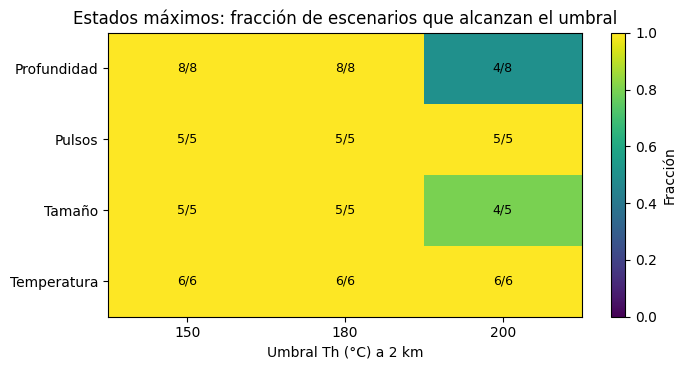

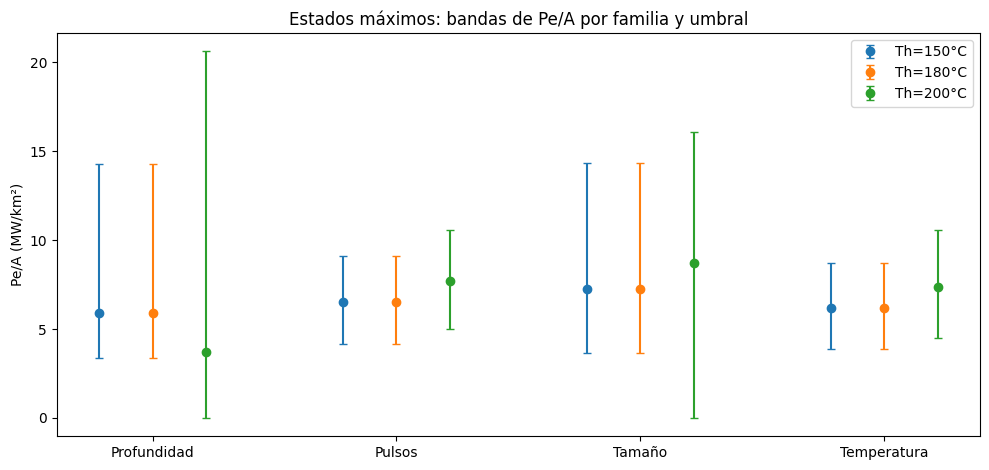

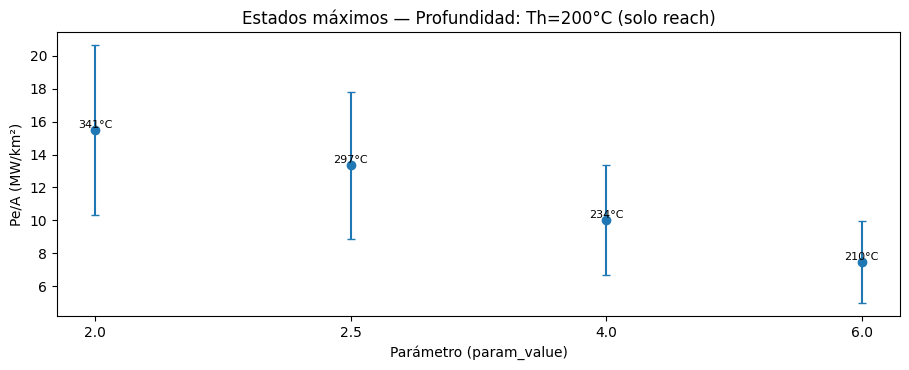

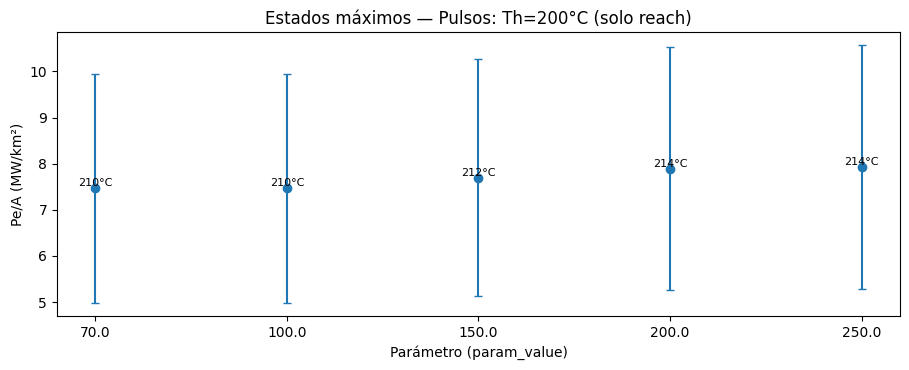

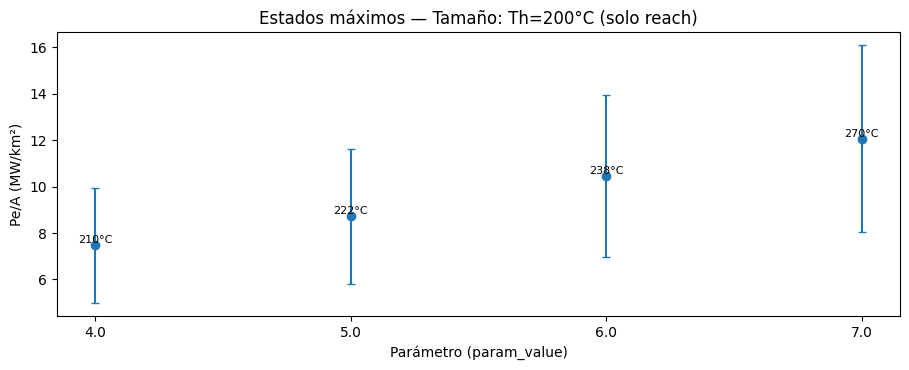

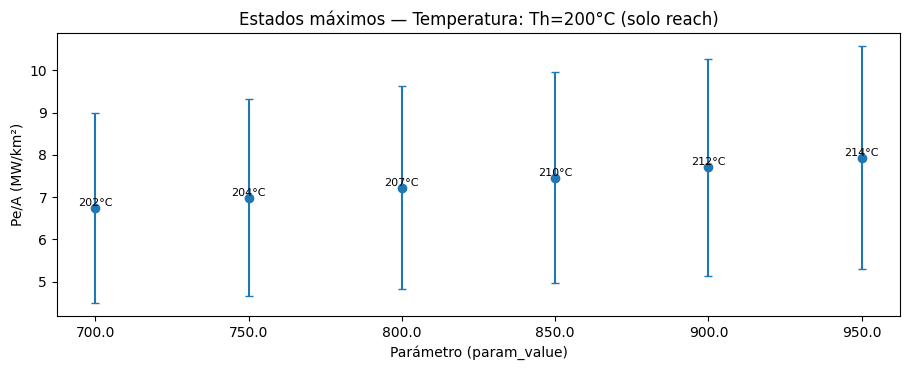

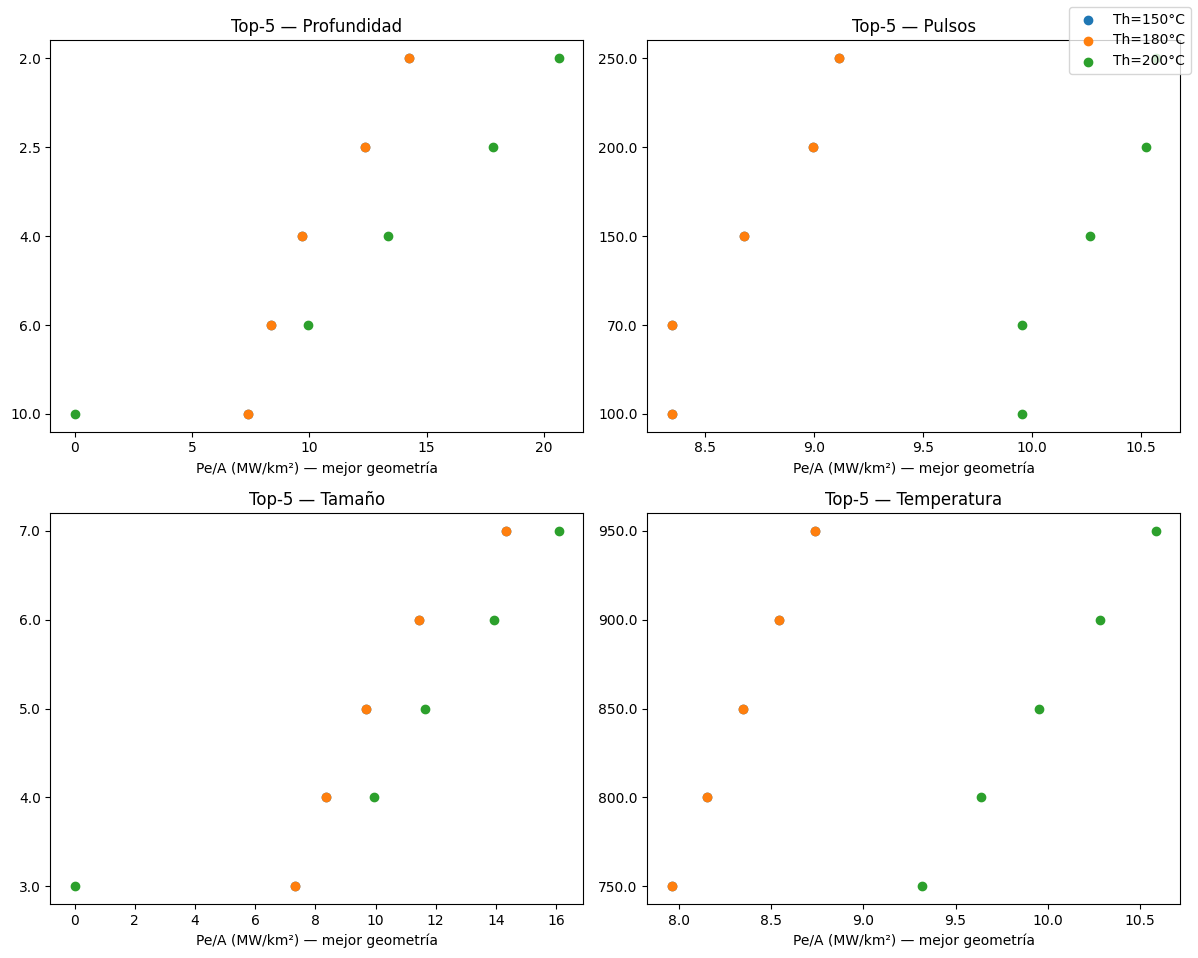

Listo. Figuras guardadas en: /home/jovyan/workspace/cerro_blanco/SETUP_B/figs_peak


In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import pot_utils as pot  # ajustá si tu módulo se llama distinto



# =========================
# INPUTS
# =========================
DF_PEAK_FULL = Path("/home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential_peak/df_peak_full.csv")              # o el path absoluto
DF_PEAK_SUMM = Path("/home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential_peak/summary_scenario_peak.csv")     # opcional para chequear

df_peak_full = pd.read_csv(DF_PEAK_FULL)
df_peak_summ = pd.read_csv(DF_PEAK_SUMM) if DF_PEAK_SUMM.exists() else None

# output
FIG_DIR = Path("figs_peak")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# CONFIG
# =========================
VALUE_COL = "Pe_MW_km2"  # Pe/A en MW/km²
TH_LIST = sorted(df_peak_full["Th_C"].unique())
FAMILY_LABELS = getattr(pot, "FAMILY_LABEL_MAP_ES", {})  # mapa ES, si existe
FAMILY_ORDER = sorted(df_peak_full["family"].unique())

# criterio de "alcanza umbral": existe intervalo a 2 km con T>=Th
# en tus tablas eso equivale a L_int_km > 0 (si no alcanza, L_int_km=0 y Pe=0)
def reaches_threshold(g):
    return bool((g["L_int_km"].astype(float) > 0).any())

# =========================
# 1) TABLA reach por escenario y Th (n/N y fracción)
# =========================
reach_scenario = (
    df_peak_full
    .groupby(["family", "scenario", "Th_C"], as_index=False)
    .apply(lambda g: pd.Series({"reach": reaches_threshold(g)}))
    .reset_index(drop=True)
)

reach_family = (
    reach_scenario
    .groupby(["family", "Th_C"], as_index=False)
    .agg(
        n_total=("reach", "size"),
        n_reach=("reach", "sum")
    )
)
reach_family["frac"] = reach_family["n_reach"] / reach_family["n_total"]

# =========================
# 2) BANDAS por escenario y por familia (min/med/max sobre geometrías)
#    Reutilizamos funciones ya presentes en pot_utils
# =========================
bands_scenario = pot.build_bands_scenario_from_steady(df_peak_full, value_col=VALUE_COL)
bands_family   = pot.build_bands_family(bands_scenario)

# =========================
# 3) “Mejor geometría” por (familia, escenario, Th): fila con máximo Pe/A
#    Sirve para Top-5 y para reportar (ts_peak, t_peak_ka, Lstrike, h) coherentes.
# =========================
def pick_best_row(g, value_col=VALUE_COL):
    i = g[value_col].astype(float).idxmax()
    r = g.loc[i]
    return pd.Series({
        "Pe_MW_km2_best": float(r[value_col]),
        "Pe_MW_best": float(r.get("Pe_MW", np.nan)),
        "ts_peak_best": int(r.get("ts_peak", r.get("ts_used", np.nan))),
        "t_peak_ka_best": float(r.get("t_peak_ka", np.nan)),
        "Lstrike_km_best": float(r.get("Lstrike_km", np.nan)),
        "h_km_best": float(r.get("h_km", np.nan)),
        "Tmean_above_C_best": float(r.get("Tmean_above_C", np.nan)),
        "L_int_km_best": float(r.get("L_int_km", np.nan)),
        "Npatches_best": float(r.get("Npatches", np.nan)),
        "param_name": r.get("param_name", ""),
        "param_value": r.get("param_value", np.nan),
    })

best_geom = (
    df_peak_full
    .groupby(["family", "scenario", "Th_C"], as_index=False)
    .apply(pick_best_row)
    .reset_index(drop=True)
)

# =========================
# PLOTS
# =========================
def plot_peak_reach_heatmap(reach_family, families=FAMILY_ORDER, Ths=TH_LIST,
                            label_map=FAMILY_LABELS, out_png=None, show=True):
    # matriz frac
    mat = np.full((len(families), len(Ths)), np.nan)
    ann = np.empty((len(families), len(Ths)), dtype=object)

    for i, fam in enumerate(families):
        for j, Th in enumerate(Ths):
            sub = reach_family[(reach_family["family"] == fam) & (reach_family["Th_C"] == Th)]
            if len(sub) == 0:
                ann[i, j] = ""
                continue
            frac = float(sub["frac"].iloc[0])
            nR = int(sub["n_reach"].iloc[0])
            nT = int(sub["n_total"].iloc[0])
            mat[i, j] = frac
            ann[i, j] = f"{nR}/{nT}"

    fig, ax = plt.subplots(figsize=(7.2, 3.8))
    im = ax.imshow(mat, aspect="auto", vmin=0, vmax=1)

    ax.set_xticks(np.arange(len(Ths)))
    ax.set_xticklabels([f"{int(t)}" for t in Ths])
    ax.set_yticks(np.arange(len(families)))
    ax.set_yticklabels([label_map.get(f, f) for f in families])

    ax.set_xlabel("Umbral Th (°C) a 2 km")
    ax.set_title("Estados máximos: fracción de escenarios que alcanzan el umbral")

    # anotaciones n/N
    for i in range(len(families)):
        for j in range(len(Ths)):
            if ann[i, j]:
                ax.text(j, i, ann[i, j], ha="center", va="center", fontsize=9)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Fracción")

    plt.tight_layout()
    if out_png:
        fig.savefig(out_png, dpi=300)
    if show:
        plt.show()
    return fig, ax


def plot_peak_pe_bands_family(bands_family, families=FAMILY_ORDER, label_map=FAMILY_LABELS,
                              out_png=None, show=True, figsize=(10, 4.8)):
    Ths = sorted(bands_family["Th_C"].unique())
    x = np.arange(len(families))
    w = 0.22

    fig, ax = plt.subplots(figsize=figsize)

    for i, Th in enumerate(Ths):
        sub = bands_family[bands_family["Th_C"] == Th].set_index("family").reindex(families)
        xi = x + (i - (len(Ths) - 1) / 2.0) * w

        ymed = sub["Pe_med"].values.astype(float)
        ymin = sub["Pe_min"].values.astype(float)
        ymax = sub["Pe_max"].values.astype(float)

        ax.errorbar(
            xi, ymed,
            yerr=[ymed - ymin, ymax - ymed],
            fmt="o", capsize=3,
            label=f"Th={int(Th)}°C"
        )

    ax.set_xticks(x)
    ax.set_xticklabels([label_map.get(f, f) for f in families])
    ax.set_ylabel("Pe/A (MW/km²)")
    ax.set_title("Estados máximos: bandas de Pe/A por familia y umbral")
    ax.legend()
    plt.tight_layout()

    if out_png:
        fig.savefig(out_png, dpi=300)
    if show:
        plt.show()
    return fig, ax


def plot_peak_th200_detail(df_peak_full, family, value_col=VALUE_COL,
                           out_png=None, show=True):
    d = df_peak_full[(df_peak_full["family"] == family) & (df_peak_full["Th_C"] == 200.0)].copy()
    d = d[d["L_int_km"].astype(float) > 0]  # sólo casos que alcanzan el umbral

    if len(d) == 0:
        print(f"[INFO] {family}: no hay casos con Th=200°C que alcancen el umbral.")
        return None, None

    # por escenario (que suele corresponder 1-1 con param_value dentro de la familia)
    gcols = ["scenario"]
    if "param_value" in d.columns:
        gcols.append("param_value")

    summ = (
        d.groupby(gcols, as_index=False)
         .agg(
             Pe_min=(value_col, "min"),
             Pe_med=(value_col, "median"),
             Pe_max=(value_col, "max"),
             Tmean_med=("Tmean_above_C", "median"),
         )
         .sort_values("param_value" if "param_value" in gcols else "scenario")
    )

    x = np.arange(len(summ))
    fig, ax = plt.subplots(figsize=(9.2, 3.8))

    ymed = summ["Pe_med"].values.astype(float)
    ymin = summ["Pe_min"].values.astype(float)
    ymax = summ["Pe_max"].values.astype(float)

    ax.errorbar(x, ymed, yerr=[ymed - ymin, ymax - ymed], fmt="o", capsize=3)
    ax.set_ylabel("Pe/A (MW/km²)")
    ax.set_title(f"Estados máximos — {FAMILY_LABELS.get(family, family)}: Th=200°C (solo reach)")

    # etiquetas X
    if "param_value" in summ.columns:
        ax.set_xticks(x)
        ax.set_xticklabels([str(v) for v in summ["param_value"].values], rotation=0)
        ax.set_xlabel("Parámetro (param_value)")
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(summ["scenario"].values, rotation=45, ha="right")
        ax.set_xlabel("Escenario")

    # anotación Tmean (mediana) arriba de cada punto
    for i, tm in enumerate(summ["Tmean_med"].values):
        if np.isfinite(tm):
            ax.text(i, ymed[i], f"{tm:.0f}°C", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    if out_png:
        fig.savefig(out_png, dpi=300)
    if show:
        plt.show()
    return fig, ax


def plot_peak_top5(best_geom, families=FAMILY_ORDER, Ths=TH_LIST,
                   out_png=None, show=True):
    # 2x2 si hay 4 familias; si no, se adapta
    nF = len(families)
    ncols = 2 if nF > 1 else 1
    nrows = int(np.ceil(nF / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for ax, fam in zip(axes, families):
        for Th in Ths:
            d = best_geom[(best_geom["family"] == fam) & (best_geom["Th_C"] == Th)].copy()
            d = d.sort_values("Pe_MW_km2_best", ascending=False).head(5)

            if len(d) == 0:
                continue

            # posición vertical (0..4) y offsets por Th
            y = np.arange(len(d))
            ax.scatter(d["Pe_MW_km2_best"].values, y, label=f"Th={int(Th)}°C")

            # etiquetas con param_value (si está)
            lab = []
            for _, r in d.iterrows():
                if "param_value" in r and np.isfinite(r["param_value"]):
                    lab.append(str(r["param_value"]))
                else:
                    lab.append(r["scenario"])
            ax.set_yticks(y)
            ax.set_yticklabels(lab)

        ax.invert_yaxis()
        ax.set_xlabel("Pe/A (MW/km²) — mejor geometría")
        ax.set_title(f"Top-5 — {FAMILY_LABELS.get(fam, fam)}")

    # limpiar ejes sobrantes
    for ax in axes[nF:]:
        ax.axis("off")

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right")
    plt.tight_layout()

    if out_png:
        fig.savefig(out_png, dpi=300)
    if show:
        plt.show()
    return fig, axes


# =========================
# RUN FIGURES
# =========================

# (a) reach heatmap
plot_peak_reach_heatmap(
    reach_family,
    families=FAMILY_ORDER,
    Ths=TH_LIST,
    label_map=FAMILY_LABELS,
    out_png=str(FIG_DIR / "Fig_peak_a_reach_heatmap.png"),
    show=True
)

# (b) bandas por familia
plot_peak_pe_bands_family(
    bands_family,
    families=FAMILY_ORDER,
    label_map=FAMILY_LABELS,
    out_png=str(FIG_DIR / "Fig_peak_b_bandas_PeA_familia.png"),
    show=True
)

# (c) detalle Th=200°C para familias donde aplique
for fam in FAMILY_ORDER:
    plot_peak_th200_detail(
        df_peak_full,
        family=fam,
        out_png=str(FIG_DIR / f"Fig_peak_c_Th200_detail_{fam}.png"),
        show=True
    )

# (d) top-5 por familia y Th usando mejor geometría
plot_peak_top5(
    best_geom,
    families=FAMILY_ORDER,
    Ths=TH_LIST,
    out_png=str(FIG_DIR / "Fig_peak_d_top5_por_familia.png"),
    show=True
)

print("Listo. Figuras guardadas en:", FIG_DIR.resolve())


In [143]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_peak_pe_violin_family(
    df_peak_full,
    families=FAMILY_ORDER,
    label_map=FAMILY_LABELS,
    out_png=None,
    out_pdf=None,
    show=True,
    figsize=(10.8, 5.0),
    only_reach=True,
    value_col=None,
    title="Estados máximos: distribución de Pe/A por familia y umbral",
):
    """
    Violines de Pe/A por familia y Th (peak / estados máximos), usando df crudo.
    Requiere df con columnas: family, Th_C, L_int_km y una columna de Pe/A en MW/km2.
    """

    df = df_peak_full.copy()

    # -------------------------
    # 0) Resolver columna de Pe/A
    # -------------------------
    if value_col is None:
        for c in ["Pe_MW_km2", "PeA_MW_km2"]:
            if c in df.columns:
                value_col = c
                break
    if value_col is None or value_col not in df.columns:
        raise RuntimeError("No encuentro columna de Pe/A en MW/km2. Probé: Pe_MW_km2, PeA_MW_km2")

    # Normalizar por si el df vino con PeA_MW_km2
    if "Pe_MW_km2" not in df.columns and "PeA_MW_km2" in df.columns:
        df["Pe_MW_km2"] = df["PeA_MW_km2"]
        if value_col == "PeA_MW_km2":
            value_col = "Pe_MW_km2"

    required = {"family", "Th_C", "L_int_km", value_col}
    missing = required - set(df.columns)
    if missing:
        raise RuntimeError(f"Faltan columnas en df_peak_full: {missing}")

    # -------------------------
    # 1) Filtrar solo reach (recomendado)
    # -------------------------
    if only_reach:
        df = df[df["L_int_km"].fillna(0.0) > 0.0].copy()

    # asegurar orden de familias
    fams = [f for f in families if f in df["family"].astype(str).unique()]
    if not fams:
        raise RuntimeError("No hay familias disponibles para plotear (df quedó vacío tras filtros).")

    Ths = sorted(df["Th_C"].dropna().unique())
    if len(Ths) == 0:
        raise RuntimeError("No hay umbrales Th_C en el df.")

    # colores por Th (C0, C1, C2, ...)
    color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

    # offsets horizontales por Th
    x0 = np.arange(len(fams))
    dx_th = 0.25

    fig, ax = plt.subplots(figsize=figsize)

    for j, Th in enumerate(Ths):
        col = color_map[Th]
        for i, fam in enumerate(fams):
            vals = df[(df["family"] == fam) & (df["Th_C"] == Th)][value_col].dropna().to_numpy(dtype=float)
            if len(vals) == 0:
                continue

            pos = x0[i] + (j - (len(Ths)-1)/2)*dx_th

            vp = ax.violinplot(
                [vals],
                positions=[pos],
                widths=0.18,
                showmedians=True,
                showextrema=False
            )

            # estilo violín
            for body in vp["bodies"]:
                body.set_facecolor(col)
                body.set_edgecolor(col)
                body.set_alpha(0.22)

            # mediana
            vp["cmedians"].set_color(col)
            vp["cmedians"].set_linewidth(1.5)

            # puntos con jitter (opcional, pero aporta)
            xj = pos + (np.random.rand(len(vals)) - 0.5) * 0.06
            ax.plot(xj, vals, "o", ms=2.6, color=col, alpha=0.45)

    # ejes / estética
    ax.set_xticks(x0)
    ax.set_xticklabels([label_map.get(f, f) for f in fams], fontsize=12)
    ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
    ax.set_title(title)
    ax.grid(True, alpha=0.25)

    # leyenda consistente
    handles = [
        Line2D([0], [0], marker="o", linestyle="",
               markerfacecolor=color_map[Th], markeredgecolor=color_map[Th],
               markersize=6, label=fr"$T_h$={int(Th)}°C")
        for Th in Ths
    ]
    ax.legend(handles=handles, loc="upper right", frameon=True)

    fig.tight_layout()

    if out_png:
        fig.savefig(out_png, dpi=300, bbox_inches="tight")
    if out_pdf:
        fig.savefig(out_pdf, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax


In [144]:
OUT

PosixPath('outputs_potential/figs_resultados')

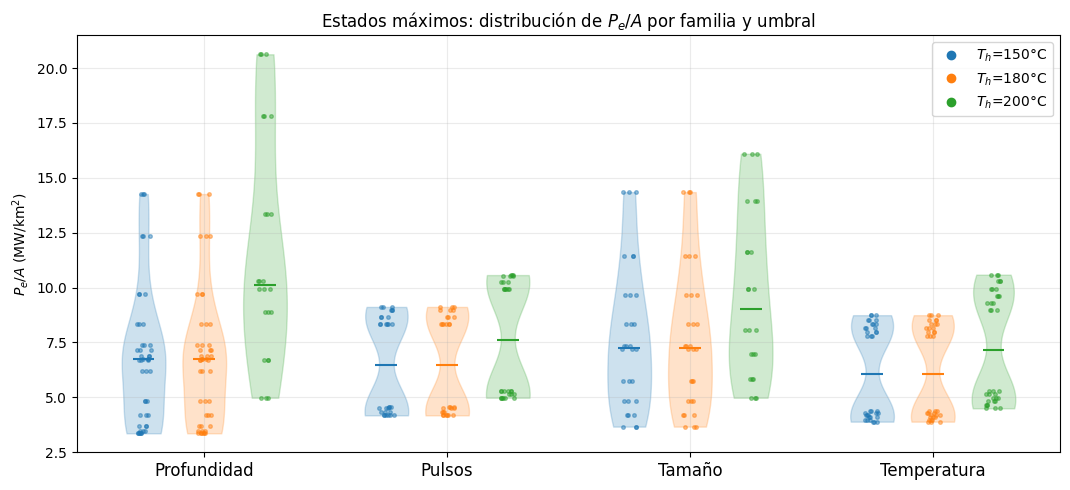

(<Figure size 1080x500 with 1 Axes>,
 <Axes: title={'center': 'Estados máximos: distribución de $P_e/A$ por familia y umbral'}, ylabel='$P_e/A$ (MW/km$^2$)'>)

In [145]:
import pandas as pd
from pathlib import Path

df_peak = pd.read_csv("outputs_potential_peak/df_peak_full.csv")

OUT = Path("outputs_potential_peak/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

plot_peak_pe_violin_family(
    df_peak,
    families=FAMILY_ORDER,
    label_map=FAMILY_LABELS,
    only_reach=True,
    out_png=OUT / "Fig_peak_PeA_violin_por_familia_y_Th_solo_reach.png",
    out_pdf=OUT / "Fig_peak_PeA_violin_por_familia_y_Th_solo_reach.pdf",
    title="Estados máximos: distribución de $P_e/A$ por familia y umbral"
)


/tmp/ipykernel_12947/1989385185.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s.groupby(["family","Th_C"], as_index=False, group_keys=False)
/tmp/ipykernel_12947/1989385185.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(topk)
/tmp/ipykernel_12947/1989385185.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

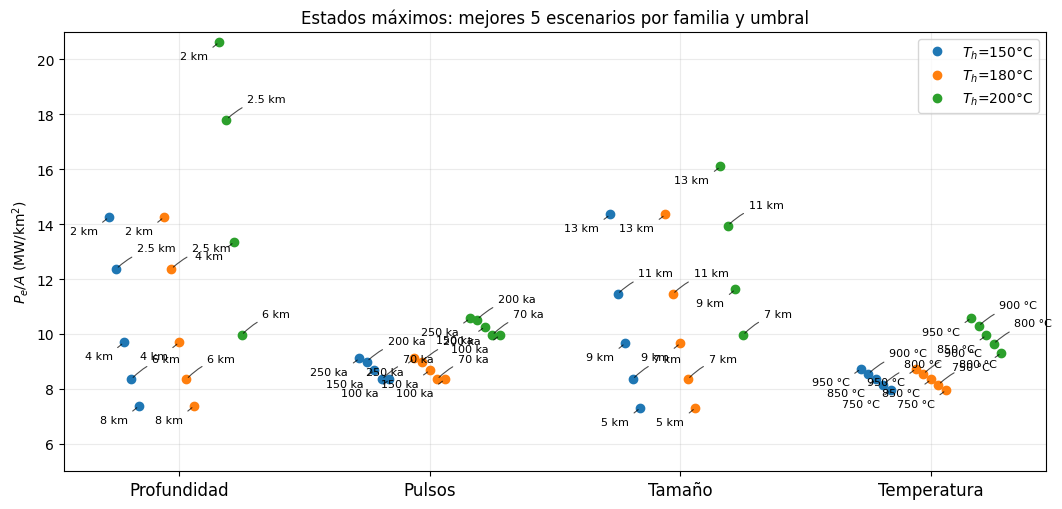

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

TOPK = 5

FAMILY_ORDER = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
FAMILY_LABEL = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

LABEL_MAP_RADIUS = {
    "R_3": "5 km",
    "R_4": "7 km",
    "R_5": "9 km",
    "R_6": "11 km",
    "R_7": "13 km",
}

OUTDIR = Path("outputs_potential_peak/figs_resultados")
OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Load (PEAK)
# -------------------------
s = pd.read_csv("/home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential_peak/summary_scenario_peak.csv")

# Normalizar nombres esperados (por si cambió alguno)
# Esperados: Th_C, Pe_MW_km2_peak, L_int_km_peak, Tmean_above_C_peak, param_value
rename_map = {}
if "Pe_MW_km2_max" in s.columns and "Pe_MW_km2_peak" not in s.columns:
    rename_map["Pe_MW_km2_max"] = "Pe_MW_km2_peak"
if "L_int_km_max" in s.columns and "L_int_km_peak" not in s.columns:
    rename_map["L_int_km_max"] = "L_int_km_peak"
if "Tmean_above_C_max" in s.columns and "Tmean_above_C_peak" not in s.columns:
    rename_map["Tmean_above_C_max"] = "Tmean_above_C_peak"
s = s.rename(columns=rename_map)

for c in ["Th_C","Pe_MW_km2_peak","L_int_km_peak","Tmean_above_C_peak","param_value"]:
    if c in s.columns:
        s[c] = pd.to_numeric(s[c], errors="coerce")

# Reach only
s = s[s["L_int_km_peak"].fillna(0.0) > 0.0].copy()

# Order families
s["family"] = pd.Categorical(s["family"], categories=FAMILY_ORDER, ordered=True)

def topk(g, k=TOPK):
    g = g.sort_values(["Pe_MW_km2_peak","Tmean_above_C_peak","L_int_km_peak"], ascending=False)
    return g.head(k)

top = (
    s.groupby(["family","Th_C"], as_index=False, group_keys=False)
     .apply(topk)
).copy()
top["rank"] = top.groupby(["family","Th_C"]).cumcount() + 1

# -------------------------
# Labels: solo número + unidad
# -------------------------
def fmt_number(v):
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return None
    if abs(v - round(v)) < 1e-9:
        return str(int(round(v)))
    return f"{v:.1f}"

def label_only_units(row):
    fam = str(row["family"])
    pval = row.get("param_value", np.nan)

    # Tamaño: mapear R_# -> "X km"
    if fam == "Chamber_Radius":
        base = str(row["scenario"]).split("_peak")[0].split("_steady")[0]  # tolerante
        return LABEL_MAP_RADIUS.get(base, base)

    # Si no hay param_value, intentamos parsear algo del nombre
    if pd.isna(pval):
        scen = str(row["scenario"])
        num = pd.to_numeric(pd.Series(scen).str.extract(r"(-?\d+\.?\d*)")[0], errors="coerce").iloc[0]
        pval = num

    if pd.isna(pval):
        return ""

    if fam == "Chamber_Depth":
        return f"{fmt_number(abs(float(pval)))} km"
    if fam == "Chamber_Pulse":
        return f"{fmt_number(float(pval))} ka"
    if fam == "Chamber_Temp":
        return f"{fmt_number(float(pval))} °C"

    return f"{fmt_number(float(pval))}"

top["label"] = top.apply(label_only_units, axis=1)

# -------------------------
# Plot (idéntico)
# -------------------------
families = [f for f in FAMILY_ORDER if f in top["family"].astype(str).unique()]
Ths = sorted(top["Th_C"].unique())

x = np.arange(len(families))
dx_th = 0.22
dx_rank = 0.03

fig, ax = plt.subplots(figsize=(10.8, 5.2))

for j, Th in enumerate(Ths):
    sub = top[top["Th_C"] == Th].copy()
    sub["x0"] = sub["family"].apply(lambda f: families.index(str(f))).astype(float)
    sub["x"] = sub["x0"] + (j - (len(Ths)-1)/2) * dx_th + (sub["rank"] - (TOPK+1)/2) * dx_rank

    ax.plot(sub["x"], sub["Pe_MW_km2_peak"], "o", label=fr"$T_h$={int(Th)}°C")

    for _, r in sub.iterrows():
        xo, yo = float(r["x"]), float(r["Pe_MW_km2_peak"])
        offy = 15 if int(r["rank"]) % 2 == 0 else -10
        dx_lab = 15 if int(r["rank"]) % 2 == 0 else -8

        ax.annotate(
            str(r["label"]),
            (xo, yo),
            textcoords="offset points",
            xytext=(dx_lab, offy),
            ha="left" if dx_lab > 0 else "right",
            va="center",
            fontsize=8,
            arrowprops=dict(
                arrowstyle="-",
                lw=0.8,
                alpha=0.7,
                shrinkA=2,
                shrinkB=2,
                connectionstyle="arc3,rad=0.15"
            )
        )

ax.set_xticks(x)
ax.set_xticklabels([FAMILY_LABEL[f] for f in families], fontsize=12)
ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
ax.set_title(f"Estados máximos: mejores {TOPK} escenarios por familia y umbral")
ax.grid(True, alpha=0.25)
ax.legend(frameon=True, loc="upper right")

# Ajustá si querés otro rango
ax.set_ylim(0, max(11, float(top["Pe_MW_km2_peak"].max()) + 0.5))
ax.set_ylim(5, 21)

fig.tight_layout()
png = OUTDIR / f"Fig_peak_top{TOPK}_reach_PeAmax_por_familia_y_Th_labels_units.png"
pdf = OUTDIR / f"Fig_peak_top{TOPK}_reach_PeAmax_por_familia_y_Th_labels_units.pdf"
fig.savefig(png, dpi=300)
fig.savefig(pdf)
plt.show()


/tmp/ipykernel_12947/4110689487.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)
/tmp/ipykernel_12947/4110689487.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)


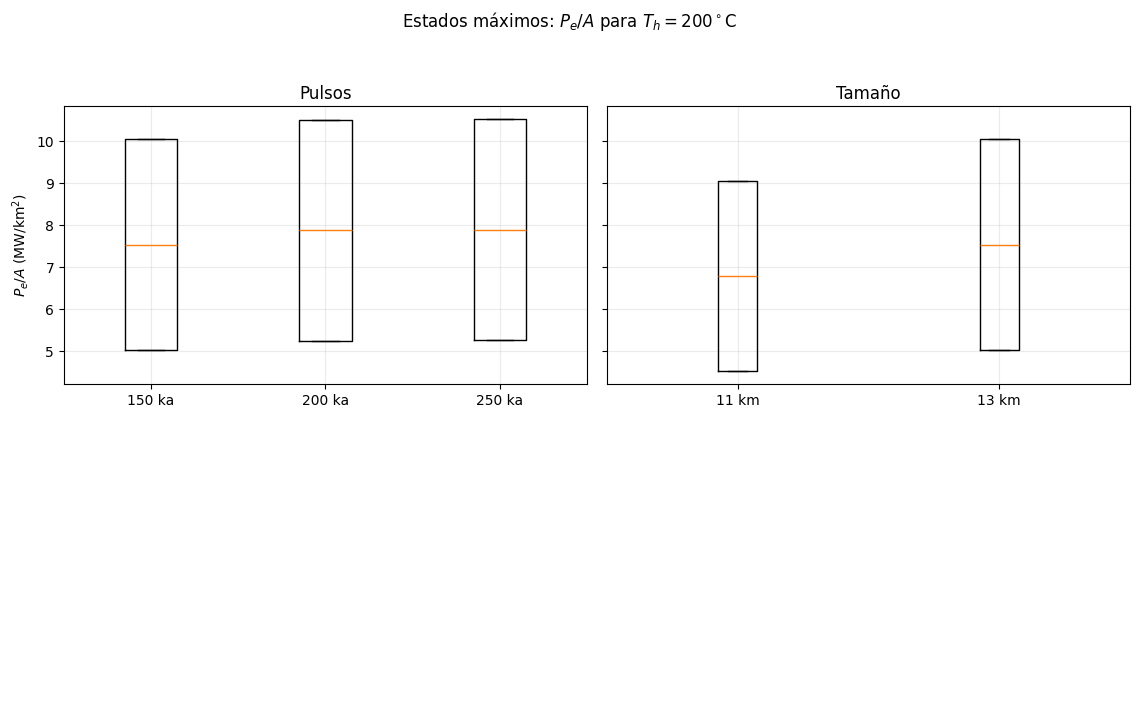

In [147]:
# -------------------------
# 5) Plot multipanel (2x2)
# -------------------------
n = len(fam_blocks)
nrows, ncols = 2, 2

# tamaño: ajustá si querés más aire
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(11.5, 7.2),
    sharey=True
)

axes = np.array(axes).ravel()

# plot en cada panel
for i, (fam, labels, data) in enumerate(fam_blocks):
    ax = axes[i]
    ax.boxplot(data, labels=labels, showfliers=False)
    ax.set_title(FAMILY_LABEL.get(fam, fam))
    ax.grid(True, alpha=0.25)
    ax.tick_params(axis="x", rotation=0)

# apagar paneles vacíos (si hubiera <4 familias)
for j in range(len(fam_blocks), nrows*ncols):
    axes[j].axis("off")

# etiquetas: y solo en la primera columna
axes[0].set_ylabel(r"$P_e/A$ (MW/km$^2$)")
axes[2].set_ylabel(r"$P_e/A$ (MW/km$^2$)")  # primera columna, segunda fila

fig.suptitle(rf"Estados máximos: $P_e/A$ para $T_h=200^\circ$C", y=0.98)

fig.tight_layout(rect=[0, 0, 1, 0.95])

png = OUT / "Fig_peak_Th200_PeA_boxplots_todas_las_familias_reach_2x2.png"
pdf = OUT / "Fig_peak_Th200_PeA_boxplots_todas_las_familias_reach_2x2.pdf"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(pdf, bbox_inches="tight")
plt.show()


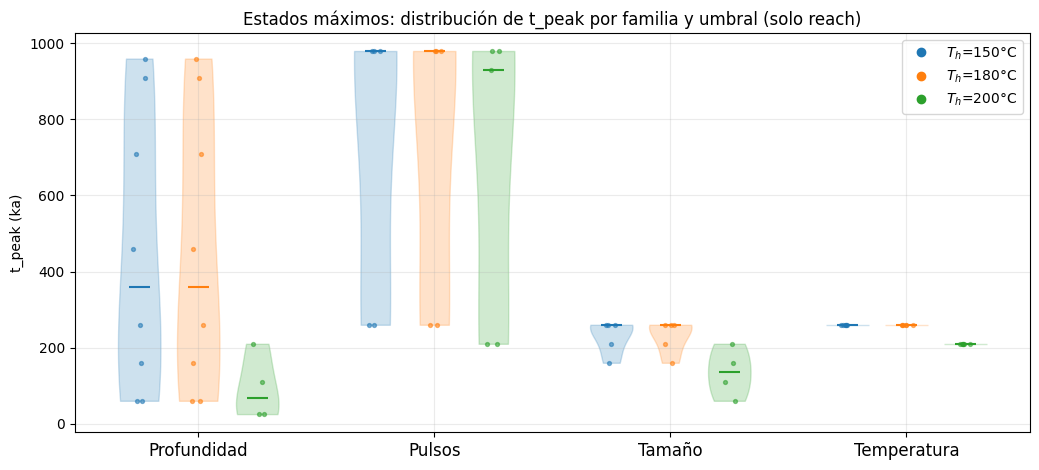

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

s = pd.read_csv("/home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential_peak/summary_scenario_peak.csv")

# solo reach (coherente con tu figura)
if "L_int_km_peak" in s.columns:
    s = s[s["L_int_km_peak"].fillna(0.0) > 0.0].copy()

# checks
if "t_peak_ka" not in s.columns:
    raise RuntimeError("No encuentro 't_peak_ka' en summary_scenario_peak.csv")

FAMILY_ORDER = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
FAMILY_LABEL = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

s["family"] = pd.Categorical(s["family"], categories=FAMILY_ORDER, ordered=True)
families = [f for f in FAMILY_ORDER if f in s["family"].astype(str).unique()]
Ths = sorted(s["Th_C"].dropna().unique())

# --- colores consistentes por Th (usa el cycle default de matplotlib)
# primer 3 colores del ciclo por defecto: C0, C1, C2
color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

dx_th = 0.25
x0 = np.arange(len(families))

fig, ax = plt.subplots(figsize=(10.5, 4.8))

# construir violines por (familia, Th) con color propio
for j, Th in enumerate(Ths):
    col = color_map[Th]
    for i, fam in enumerate(families):
        vals = s[(s["family"] == fam) & (s["Th_C"] == Th)]["t_peak_ka"].dropna().to_numpy()
        if len(vals) == 0:
            continue

        pos = x0[i] + (j - (len(Ths)-1)/2)*dx_th

        vp = ax.violinplot(
            [vals],
            positions=[pos],
            widths=0.18,
            showmedians=True,
            showextrema=False
        )

        # colorear el violín
        for body in vp["bodies"]:
            body.set_facecolor(col)
            body.set_edgecolor(col)
            body.set_alpha(0.22)

        # mediana en el mismo color (y un poco más visible)
        vp["cmedians"].set_color(col)
        vp["cmedians"].set_linewidth(1.5)

        # puntos con jitter y color por Th
        xj = pos + (np.random.rand(len(vals)) - 0.5) * 0.06
        ax.plot(xj, vals, "o", ms=2.8, color=col, alpha=0.55)

ax.set_xticks(x0)
ax.set_xticklabels([FAMILY_LABEL.get(f, f) for f in families], fontsize=12)
ax.set_ylabel("t_peak (ka)")
ax.set_title("Estados máximos: distribución de t_peak por familia y umbral (solo reach)")
ax.grid(True, alpha=0.25)

# leyenda correcta (color ↔ Th)
handles = [
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor=color_map[Th], markeredgecolor=color_map[Th],
           markersize=6, label=fr"$T_h$={int(Th)}°C")
    for Th in Ths
]
ax.legend(handles=handles, loc="upper right", frameon=True)

fig.tight_layout()
plt.show()


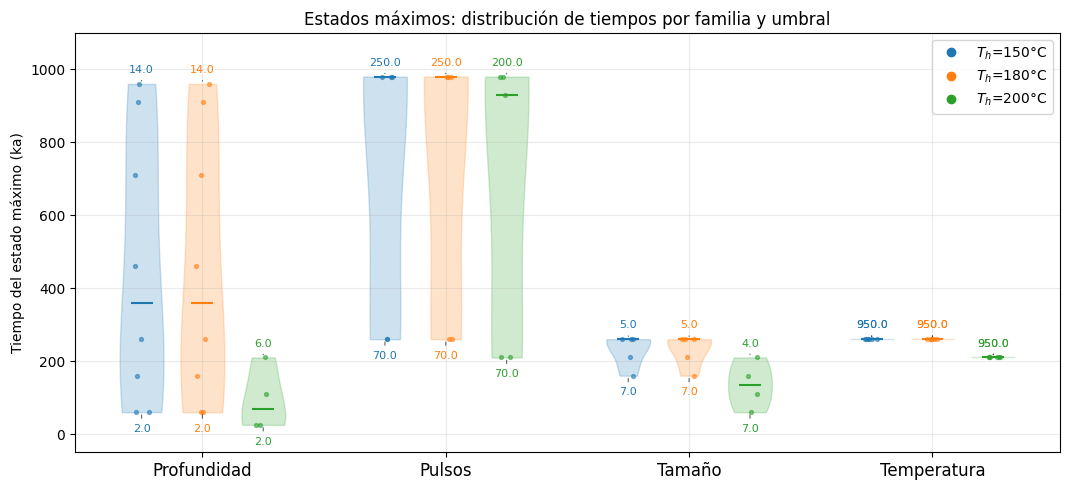

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

s = pd.read_csv("/home/jovyan/workspace/cerro_blanco/SETUP_B/outputs_potential_peak/summary_scenario_peak.csv")
if "L_int_km_peak" in s.columns:
    s = s[s["L_int_km_peak"].fillna(0.0) > 0.0].copy()

FAMILY_ORDER = ["Chamber_Depth","Chamber_Pulse","Chamber_Radius","Chamber_Temp"]
FAMILY_LABEL = {"Chamber_Depth":"Profundidad","Chamber_Pulse":"Pulsos","Chamber_Radius":"Tamaño","Chamber_Temp":"Temperatura"}

s["family"] = pd.Categorical(s["family"], categories=FAMILY_ORDER, ordered=True)
families = [f for f in FAMILY_ORDER if f in s["family"].astype(str).unique()]
Ths = sorted(s["Th_C"].dropna().unique())
color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

dx_th = 0.25
x0 = np.arange(len(families))

fig, ax = plt.subplots(figsize=(10.8, 5.0))

for j, Th in enumerate(Ths):
    col = color_map[Th]
    for i, fam in enumerate(families):
        g = s[(s["family"] == fam) & (s["Th_C"] == Th)].dropna(subset=["t_peak_ka"]).copy()
        if g.empty:
            continue

        vals = g["t_peak_ka"].to_numpy()
        pos = x0[i] + (j - (len(Ths)-1)/2)*dx_th

        vp = ax.violinplot([vals], positions=[pos], widths=0.18, showmedians=True, showextrema=False)
        for body in vp["bodies"]:
            body.set_facecolor(col); body.set_edgecolor(col); body.set_alpha(0.22)
        vp["cmedians"].set_color(col); vp["cmedians"].set_linewidth(1.5)

        # puntos
        xj = pos + (np.random.rand(len(vals)) - 0.5) * 0.06
        ax.plot(xj, vals, "o", ms=2.8, color=col, alpha=0.55)

        # ---- etiquetas: min y max ----
        # texto corto: param_value si existe, si no scenario
        def short_label(row):
            if "param_value" in row and pd.notna(row["param_value"]):
                return f'{row["param_value"]}'
            return str(row.get("scenario",""))

        idx_min = g["t_peak_ka"].idxmin()
        idx_max = g["t_peak_ka"].idxmax()

        for k, idx in enumerate([idx_min, idx_max]):
            r = g.loc[idx]
            y = float(r["t_peak_ka"])
            # ubicar el texto cerca del punto (arriba para max, abajo para min)
            dy = 10 if idx == idx_max else -12
            ax.annotate(
                short_label(r),
                (pos, y),
                textcoords="offset points",
                xytext=(0, dy),
                ha="center",
                va="center",
                fontsize=8,
                color=col,
                arrowprops=dict(arrowstyle="-", lw=0.8, alpha=0.6)
            )

ax.set_xticks(x0)
ax.set_xticklabels([FAMILY_LABEL.get(f, f) for f in families], fontsize=12)
ax.set_ylabel("Tiempo del estado máximo (ka)")
ax.set_title("Estados máximos: distribución de tiempos por familia y umbral")
ax.grid(True, alpha=0.25)

handles = [Line2D([0],[0], marker="o", linestyle="", color=color_map[Th], label=fr"$T_h$={int(Th)}°C") for Th in Ths]
ax.legend(handles=handles, loc="upper right", frameon=True)
ax.set_ylim(-50, 1100)

fig.tight_layout()

png = OUT / "Fig_peak_tpeak_violin_por_familia_y_Th_reach_minmax.png"
pdf = OUT / "Fig_peak_tpeak_violin_por_familia_y_Th_reach_minmax.pdf"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(pdf, bbox_inches="tight")

plt.show()


In [150]:
OUT

PosixPath('outputs_potential_peak/figs_resultados')

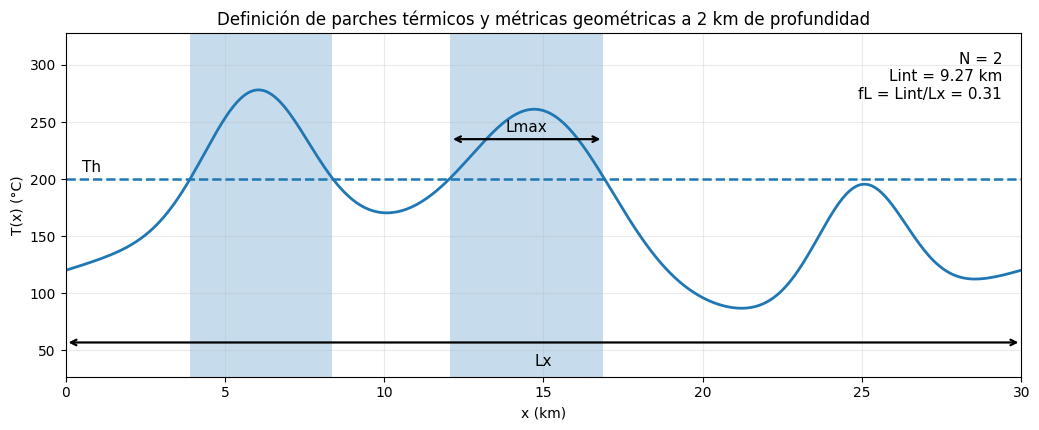

{'N': 2,
 'Lint': 9.265442404006677,
 'Lmax': 4.808013355592655,
 'fL': 0.3088480801335559}

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def fig_schema_reservorio(
    out_png="Fig_schema_reservorio_parametros.png",
    out_pdf="Fig_schema_reservorio_parametros.pdf",
    Lx=30.0,
    Th=200.0
):
    # Perfil sintético con 3 "parches" sobre el umbral
    x = np.linspace(0, Lx, 600)
    T = 120 + 40*np.sin(2*np.pi*x/Lx)  # base
    # agrego 3 anomalías para simular parches
    T += 120*np.exp(-0.5*((x-6)/1.6)**2)
    T += 140*np.exp(-0.5*((x-15)/2.2)**2)
    T += 110*np.exp(-0.5*((x-25)/1.4)**2)

    # máscara de umbral
    mask = T >= Th

    # detectar intervalos continuos (en x)
    idx = np.where(mask)[0]
    intervals = []
    if idx.size > 0:
        # cortes donde se rompe la continuidad
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[idx[0], idx[breaks + 1]]
        ends   = np.r_[idx[breaks], idx[-1]]
        for s, e in zip(starts, ends):
            intervals.append((x[s], x[e]))

    # métricas
    N = len(intervals)
    lengths = [b-a for a,b in intervals]
    Lint = float(np.sum(lengths)) if lengths else 0.0
    Lmax = float(np.max(lengths)) if lengths else 0.0
    fL = Lint / Lx if Lx > 0 else np.nan

    # -------- Plot --------
    fig, ax = plt.subplots(figsize=(10.5, 4.4))

    ax.plot(x, T, lw=2)
    ax.axhline(Th, ls="--", lw=1.8)
    ax.text(0.5, Th+6, "Th", fontsize=11)

    # sombrear parches
    for (a,b) in intervals:
        ax.axvspan(a, b, alpha=0.25)

    # anotar Lx
    y0 = np.min(T) - 30
    ax.annotate("", xy=(0, y0), xytext=(Lx, y0),
                arrowprops=dict(arrowstyle="<->", lw=1.6))
    ax.text(Lx/2, y0-10, "Lx", ha="center", va="top", fontsize=11)

    # anotar Lmax sobre el parche más largo
    if N > 0:
        i_max = int(np.argmax(lengths))
        a, b = intervals[i_max]
        y1 = Th + 35
        ax.annotate("", xy=(a, y1), xytext=(b, y1),
                    arrowprops=dict(arrowstyle="<->", lw=1.6))
        ax.text((a+b)/2, y1+6, "Lmax", ha="center", fontsize=11)

    # texto con métricas
    txt = f"N = {N}\nLint = {Lint:.2f} km\nfL = Lint/Lx = {fL:.2f}"
    ax.text(0.98, 0.80, txt, transform=ax.transAxes,
            ha="right", va="bottom", fontsize=11)

    ax.set_xlabel("x (km)")
    ax.set_ylabel("T(x) (°C)")
    ax.set_title("Definición de parches térmicos y métricas geométricas a 2 km de profundidad")
    ax.set_xlim(0, Lx)

    # margen inferior para que entre Lx
    ax.set_ylim(np.min(T)-60, np.max(T)+50)
    ax.grid(True, alpha=0.25)

    fig.tight_layout()

    out_png = Path(out_png)
    out_pdf = Path(out_pdf)
    out_png.parent.mkdir(parents=True, exist_ok=True)

    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    return {"N": N, "Lint": Lint, "Lmax": Lmax, "fL": fL}

# ejemplo
fig_schema_reservorio()


In [152]:
import pandas as pd
import numpy as np
from pathlib import Path

# -------------------------
# Config
# -------------------------
CSV = "outputs_potential/df_all.csv"   # tu df base (steady)
OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

TOPK = 5
ONLY_REACH = True  # consistente con el ranking "reach": L_int_km > 0

LABEL_MAP_RADIUS = {
    "R_3": "5 km",
    "R_4": "7 km",
    "R_5": "9 km",
    "R_6": "11 km",
    "R_7": "13 km",
}

FAMILY_LABEL = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

FAMILY_ORDER = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]

# -------------------------
# Load
# -------------------------
df = pd.read_csv(CSV)

# Normalizar nombre de Pe/A
if "Pe_MW_km2" not in df.columns and "PeA_MW_km2" in df.columns:
    df["Pe_MW_km2"] = df["PeA_MW_km2"]

required = {"family","scenario","Th_C","Pe_MW_km2","Lstrike_km","h_km","L_int_km","Lmax_km","Npatches","Tmean_above_C"}
missing = required - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en df_all.csv: {missing}")

# Reach-only (consistente con tu summary/ranking anterior)
if ONLY_REACH:
    df = df[df["L_int_km"].fillna(0.0) > 0.0].copy()

# Orden familias
df["family"] = pd.Categorical(df["family"], categories=FAMILY_ORDER, ordered=True)

# -------------------------
# Etiqueta "humana" del parámetro explorado
# -------------------------
def fmt_number(v):
    if pd.isna(v):
        return ""
    v = float(v)
    if abs(v - round(v)) < 1e-9:
        return str(int(round(v)))
    return f"{v:.1f}"

def scenario_label(row):
    fam = str(row["family"])
    scen = str(row["scenario"])
    pval = row.get("param_value", np.nan)

    # Tamaño: mapear R_# -> "X km" si aparece
    if fam == "Chamber_Radius":
        rkey = pd.Series([scen]).str.extract(r"(R_\d+)")[0].iloc[0]
        if isinstance(rkey, str) and rkey in LABEL_MAP_RADIUS:
            return LABEL_MAP_RADIUS[rkey]
        # fallback
        return scen

    # usar param_value si existe
    if not pd.isna(pval):
        if fam == "Chamber_Depth":
            return f"{fmt_number(abs(float(pval)))} km"
        if fam == "Chamber_Pulse":
            return f"{fmt_number(float(pval))} ka"
        if fam == "Chamber_Temp":
            return f"{fmt_number(float(pval))} °C"
        return fmt_number(float(pval))

    # fallback: extraer número del nombre del scenario
    num = pd.to_numeric(pd.Series([scen]).str.extract(r"(-?\d+\.?\d*)")[0], errors="coerce").iloc[0]
    if pd.isna(num):
        return scen

    if fam == "Chamber_Depth":
        return f"{fmt_number(abs(float(num)))} km"
    if fam == "Chamber_Pulse":
        return f"{fmt_number(float(num))} ka"
    if fam == "Chamber_Temp":
        return f"{fmt_number(float(num))} °C"
    return fmt_number(float(num))

# -------------------------
# 1) Para cada (family, Th, scenario): elegir la geometría que maximiza Pe/A
# -------------------------
idx = df.groupby(["family","Th_C","scenario"], observed=True)["Pe_MW_km2"].idxmax()

best_geom = df.loc[idx].copy()

best_geom["family_label"] = best_geom["family"].astype(str).map(FAMILY_LABEL).fillna(best_geom["family"].astype(str))
best_geom["param_label"] = best_geom.apply(scenario_label, axis=1)

# -------------------------
# 2) Rankear por familia y Th y quedarnos con TOPK
# -------------------------
best_geom = best_geom.sort_values(["family","Th_C","Pe_MW_km2"], ascending=[True, True, False])
best_geom["rank"] = best_geom.groupby(["family","Th_C"]).cumcount() + 1
top = best_geom[best_geom["rank"] <= TOPK].copy()

# -------------------------
# 3) Armar tabla final (columnas útiles)
# -------------------------
cols = [
    "family_label", "Th_C", "rank", "param_label",
    "Pe_MW_km2", "Pe_MW",
    "Lstrike_km", "h_km",
    "L_int_km", "Lmax_km", "Npatches", "Tmean_above_C",
    "scenario", "model_dir", "ts"
]
# Algunas columnas pueden no estar (Pe_MW a veces sí); filtramos seguro
cols = [c for c in cols if c in top.columns]
tab = top[cols].copy()

# Redondeos amigables
for c in ["Pe_MW_km2","Pe_MW","Lstrike_km","h_km","L_int_km","Lmax_km","Tmean_above_C"]:
    if c in tab.columns:
        tab[c] = pd.to_numeric(tab[c], errors="coerce")

tab = tab.sort_values(["family_label","Th_C","rank"])
tab["Th_C"] = tab["Th_C"].astype(int)

# -------------------------
# 4) Guardar
# -------------------------
out_csv = OUT / f"Table_steady_top{TOPK}_por_familia_y_Th_con_Lstrike_h.csv"
tab.to_csv(out_csv, index=False)

# Opcional: LaTeX (por si lo querés directo a la tesis)
out_tex = OUT / f"Table_steady_top{TOPK}_por_familia_y_Th_con_Lstrike_h.tex"
with open(out_tex, "w", encoding="utf-8") as f:
    f.write(tab.to_latex(index=False, float_format="%.2f"))

print("Guardado:")
print(" -", out_csv)
print(" -", out_tex)
print("\nPreview:")
print(tab.head(12).to_string(index=False))


Guardado:
 - outputs_potential/figs_resultados/Table_steady_top5_por_familia_y_Th_con_Lstrike_h.csv
 - outputs_potential/figs_resultados/Table_steady_top5_por_familia_y_Th_con_Lstrike_h.tex

Preview:
family_label  Th_C  rank param_label  Pe_MW_km2       Pe_MW  Lstrike_km  h_km  L_int_km  Lmax_km  Npatches  Tmean_above_C                         scenario                                                                                  model_dir  ts
 Profundidad   150     1        6 km   7.418483 2225.544995        10.0   1.0   30.0000  30.0000         1     188.325962   Depth_6.0_steady-state_256x256   /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_6.0_steady-state_256x256 103
 Profundidad   150     2        2 km   7.311766 3058.943234        15.0   1.0   27.8906  13.9453         2     187.363711   Depth_2.0_steady-state_256x256   /home/jovyan/workspace/cerro_blanco/SETUP_B/Chamber_Depth/Depth_2.0_steady-state_256x256 103
 Profundidad   150     3        4 km   7.215489 21

/tmp/ipykernel_12947/4263884437.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_geom["rank"] = best_geom.groupby(["family","Th_C"]).cumcount() + 1


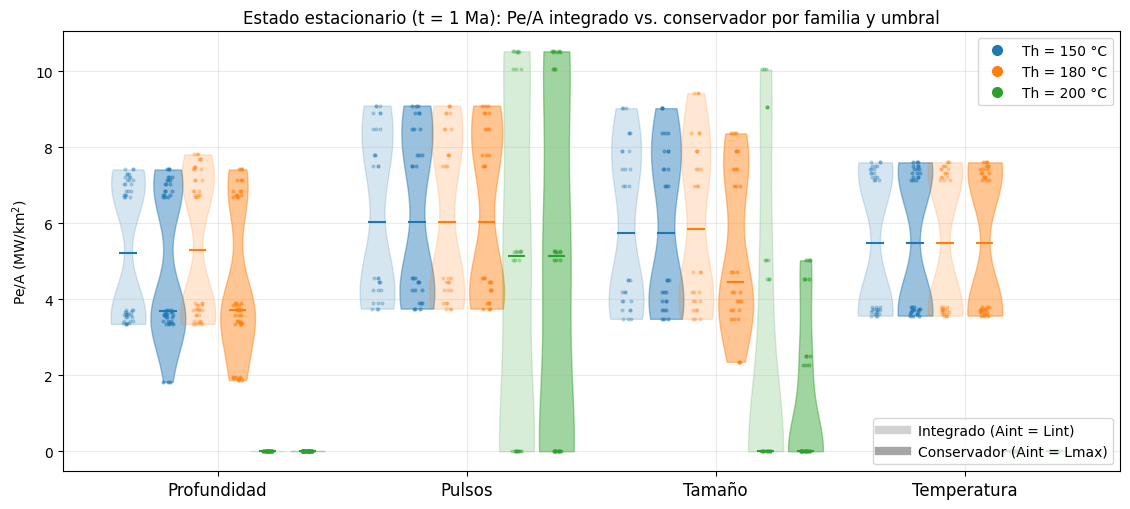

Guardado: outputs_potential/figs_resultados/Fig_steady_PeA_integrado_vs_conservador_violin_por_familia_y_Th.png


In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# -------------------------
# Inputs / outputs
# -------------------------
CSV = "outputs_potential/df_all.csv"
OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

OUTPNG = OUT / "Fig_steady_PeA_integrado_vs_conservador_violin_por_familia_y_Th.png"
OUTPDF = OUT / "Fig_steady_PeA_integrado_vs_conservador_violin_por_familia_y_Th.pdf"

# -------------------------
# Load
# -------------------------
df = pd.read_csv(CSV)

# normalizar nombre de Pe/A
if "Pe_MW_km2" not in df.columns and "PeA_MW_km2" in df.columns:
    df["Pe_MW_km2"] = df["PeA_MW_km2"]

required = {"family","Th_C","L_int_km","Lmax_km","Pe_MW_km2"}
missing = required - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en df_all.csv: {missing}")

# -------------------------
# Config familias
# -------------------------
order = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
label_map = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

df["family"] = pd.Categorical(df["family"], categories=order, ordered=True)
df = df.sort_values(["family","Th_C"])

families = [f for f in order if f in df["family"].astype(str).unique()]
Ths = sorted(df["Th_C"].dropna().unique())

# colores por Th (mismos que venís usando: C0, C1, C2...)
color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

# -------------------------
# 1) Construir Pe/A conservador (Aint = Lmax) como re-escalado geométrico
# -------------------------
Lint = df["L_int_km"].to_numpy(dtype=float)
Lmax = df["Lmax_km"].to_numpy(dtype=float)
PeA_int = df["Pe_MW_km2"].to_numpy(dtype=float)

ratio = np.zeros_like(PeA_int, dtype=float)
mask = np.isfinite(Lint) & (Lint > 0) & np.isfinite(Lmax)
ratio[mask] = Lmax[mask] / Lint[mask]

PeA_cons = np.zeros_like(PeA_int, dtype=float)
PeA_cons[mask] = PeA_int[mask] * ratio[mask]

df["PeA_int_MW_km2"] = PeA_int
df["PeA_cons_MW_km2"] = PeA_cons

# -------------------------
# 2) Plot: violines pareados (integrado vs conservador) por familia y Th
# -------------------------
x0 = np.arange(len(families))
dx_th = 0.28       # separación entre umbrales
dx_kind = 0.08     # separación integrado vs conservador dentro de cada umbral

fig, ax = plt.subplots(figsize=(11.4, 5.2))

for j, Th in enumerate(Ths):
    col = color_map[Th]
    for i, fam in enumerate(families):
        dsub = df[(df["family"] == fam) & (df["Th_C"] == Th)].copy()
        if dsub.empty:
            continue

        # valores
        v_int = dsub["PeA_int_MW_km2"].dropna().to_numpy(dtype=float)
        v_con = dsub["PeA_cons_MW_km2"].dropna().to_numpy(dtype=float)

        if len(v_int) == 0 and len(v_con) == 0:
            continue

        base = x0[i] + (j - (len(Ths)-1)/2) * dx_th
        pos_int = base - dx_kind
        pos_con = base + dx_kind

        # violín integrado
        if len(v_int) > 0:
            vp = ax.violinplot([v_int], positions=[pos_int], widths=0.14,
                               showmedians=True, showextrema=False)
            for body in vp["bodies"]:
                body.set_facecolor(col)
                body.set_edgecolor(col)
                body.set_alpha(0.18)
            vp["cmedians"].set_color(col)
            vp["cmedians"].set_linewidth(1.5)

        # violín conservador (un poco más opaco para distinguir)
        if len(v_con) > 0:
            vp2 = ax.violinplot([v_con], positions=[pos_con], widths=0.14,
                                showmedians=True, showextrema=False)
            for body in vp2["bodies"]:
                body.set_facecolor(col)
                body.set_edgecolor(col)
                body.set_alpha(0.45)
            vp2["cmedians"].set_color(col)
            vp2["cmedians"].set_linewidth(1.5)

        # puntos (jitter) — opcional, te lo dejo suave
        xj_int = pos_int + (np.random.rand(len(v_int)) - 0.5) * 0.04
        xj_con = pos_con + (np.random.rand(len(v_con)) - 0.5) * 0.04
        ax.plot(xj_int, v_int, "o", ms=2.0, color=col, alpha=0.25)
        ax.plot(xj_con, v_con, "o", ms=2.0, color=col, alpha=0.45)

# ejes / estética
ax.set_xticks(x0)
ax.set_xticklabels([label_map.get(f, f) for f in families], fontsize=12)
ax.set_ylabel("Pe/A (MW/km$^2$)")
ax.set_title("Estado estacionario (t = 1 Ma): Pe/A integrado vs. conservador por familia y umbral")
ax.grid(True, alpha=0.25)

# leyendas: Th por color + estilo integrado/conservador
handles_th = [
    Line2D([0],[0], marker="o", linestyle="",
           markerfacecolor=color_map[Th], markeredgecolor=color_map[Th],
           markersize=7, label=f"Th = {int(Th)} °C")
    for Th in Ths
]
handles_kind = [
    Line2D([0],[0], color="k", lw=6, alpha=0.18, label="Integrado (Aint = Lint)"),
    Line2D([0],[0], color="k", lw=6, alpha=0.35, label="Conservador (Aint = Lmax)")
]
leg1 = ax.legend(handles=handles_th, loc="upper right", frameon=True)
ax.add_artist(leg1)
ax.legend(handles=handles_kind, loc="lower right", frameon=True)

fig.tight_layout()
fig.savefig(OUTPNG, dpi=300, bbox_inches="tight")
fig.savefig(OUTPDF, bbox_inches="tight")
plt.show()

print("Guardado:", OUTPNG)


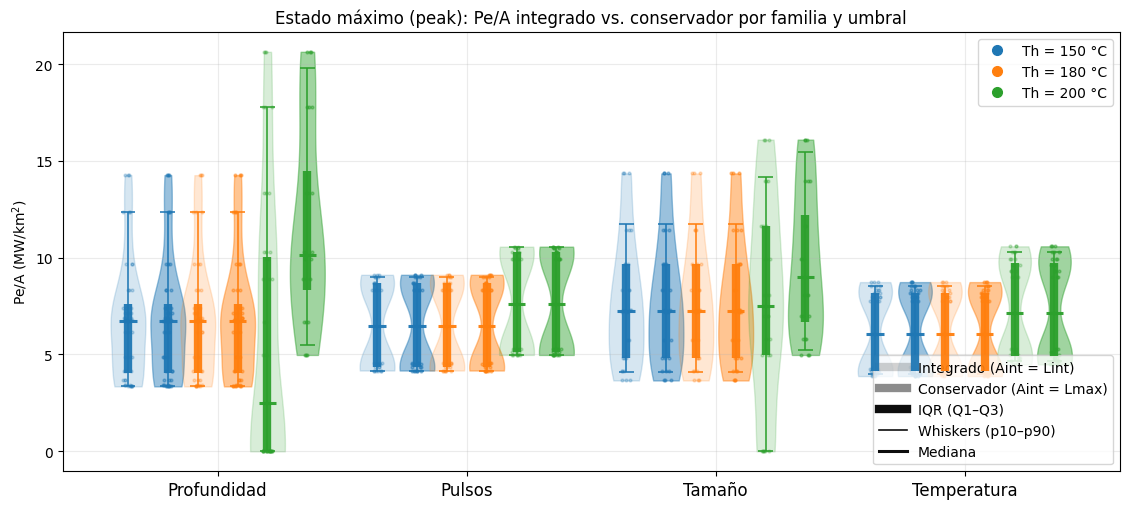

Guardado: outputs_potential/figs_resultados/Fig_peak_PeA_integrado_vs_conservador_violin_por_familia_y_Th__IQR_whiskers.png


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# -------------------------
# Inputs / outputs
# -------------------------
CSV = "outputs_potential_peak/df_peak_full.csv"   # <-- tu archivo PEAK
OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

OUTPNG = OUT / "Fig_peak_PeA_integrado_vs_conservador_violin_por_familia_y_Th__IQR_whiskers.png"
OUTPDF = OUT / "Fig_peak_PeA_integrado_vs_conservador_violin_por_familia_y_Th__IQR_whiskers.pdf"

# -------------------------
# Load
# -------------------------
df = pd.read_csv(CSV)

# Normalizar nombre de Pe/A (integrado)
if "Pe_MW_km2" not in df.columns and "PeA_MW_km2" in df.columns:
    df["Pe_MW_km2"] = df["PeA_MW_km2"]

required = {"family", "Th_C", "L_int_km", "Lmax_km", "Pe_MW_km2"}
missing = required - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en {CSV}: {missing}")

# (Opcional) confirmar que es dataset peak
if "peak_of" in df.columns:
    vals = set(df["peak_of"].dropna().astype(str).unique().tolist())
    if not ("Pe_MW_km2" in vals or "PeA_MW_km2" in vals):
        print("Aviso: 'peak_of' no indica Pe_MW_km2/PeA_MW_km2. Valores:", sorted(vals))

# -------------------------
# Config familias
# -------------------------
order = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
label_map = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

df["family"] = pd.Categorical(df["family"], categories=order, ordered=True)
df = df.sort_values(["family", "Th_C"])

families = [f for f in order if f in df["family"].astype(str).unique()]
Ths = sorted(df["Th_C"].dropna().unique())

# colores por Th (C0, C1, C2...)
color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

# -------------------------
# 1) Pe/A conservador (Aint = Lmax) como re-escalado geométrico
# -------------------------
Lint = df["L_int_km"].to_numpy(dtype=float)
Lmax = df["Lmax_km"].to_numpy(dtype=float)
PeA_int = df["Pe_MW_km2"].to_numpy(dtype=float)

mask = np.isfinite(Lint) & (Lint > 0) & np.isfinite(Lmax) & (Lmax >= 0)

PeA_cons = np.full_like(PeA_int, np.nan, dtype=float)
PeA_cons[mask] = PeA_int[mask] * (Lmax[mask] / Lint[mask])

df["PeA_int_MW_km2"] = PeA_int
df["PeA_cons_MW_km2"] = PeA_cons

# -------------------------
# Helper: IQR + whiskers + mediana (+ media opcional)
# -------------------------
def add_iqr_whiskers(ax, pos, vals, col, *, whisker_perc=(10, 90),
                     halfwidth_med=0.035, cap=0.030,
                     lw_whisk=1.2, lw_iqr=6.0, lw_med=2.2,
                     alpha=0.95, zorder=6, show_mean=False):
    """
    Dibuja:
      - whiskers: percentiles whisker_perc (default p10-p90)
      - IQR: Q1-Q3 como barra vertical gruesa
      - mediana: línea horizontal
      - (opcional) media: diamante
    """
    vals = np.asarray(vals, dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return

    q1, med, q3 = np.percentile(vals, [25, 50, 75])
    p_lo, p_hi = np.percentile(vals, list(whisker_perc))

    # Whiskers
    ax.vlines(pos, p_lo, p_hi, color=col, linewidth=lw_whisk, alpha=alpha, zorder=zorder-1)
    ax.hlines([p_lo, p_hi], pos-cap, pos+cap, color=col, linewidth=lw_whisk, alpha=alpha, zorder=zorder-1)

    # IQR
    ax.vlines(pos, q1, q3, color=col, linewidth=lw_iqr, alpha=alpha, zorder=zorder)

    # Mediana
    ax.hlines(med, pos-halfwidth_med, pos+halfwidth_med, color=col, linewidth=lw_med, alpha=alpha, zorder=zorder+1)

    # Media opcional
    if show_mean:
        mean = np.mean(vals)
        ax.plot(pos, mean, marker="D", ms=4.5, color=col, alpha=alpha, zorder=zorder+2)

# -------------------------
# 2) Plot: violines pareados (integrado vs conservador) por familia y Th
# -------------------------
x0 = np.arange(len(families))
dx_th = 0.28       # separación entre umbrales
dx_kind = 0.08     # separación integrado vs conservador dentro de cada umbral

fig, ax = plt.subplots(figsize=(11.4, 5.2))
rng = np.random.default_rng(123)  # jitter reproducible

# whiskers como p10–p90 (cambiá a (5,95) si querés más “rango”)
WHISK = (10, 90)

for j, Th in enumerate(Ths):
    col = color_map[Th]
    for i, fam in enumerate(families):
        dsub = df[(df["family"] == fam) & (df["Th_C"] == Th)]
        if dsub.empty:
            continue

        v_int = dsub["PeA_int_MW_km2"].dropna().to_numpy(dtype=float)
        v_con = dsub["PeA_cons_MW_km2"].dropna().to_numpy(dtype=float)

        if len(v_int) == 0 and len(v_con) == 0:
            continue

        base = x0[i] + (j - (len(Ths)-1)/2) * dx_th
        pos_int = base - dx_kind
        pos_con = base + dx_kind

        # ---------------------------------------------------
        # Violines (sin mediana interna; la ponemos nosotros)
        # ---------------------------------------------------
        if len(v_int) > 0:
            vp = ax.violinplot([v_int], positions=[pos_int], widths=0.14,
                               showmedians=False, showextrema=False)
            for body in vp["bodies"]:
                body.set_facecolor(col)
                body.set_edgecolor(col)
                body.set_alpha(0.18)

            # IQR + whiskers + mediana (y media opcional)
            add_iqr_whiskers(ax, pos_int, v_int, col, whisker_perc=WHISK, alpha=0.95, show_mean=False)

        if len(v_con) > 0:
            vp2 = ax.violinplot([v_con], positions=[pos_con], widths=0.14,
                                showmedians=False, showextrema=False)
            for body in vp2["bodies"]:
                body.set_facecolor(col)
                body.set_edgecolor(col)
                body.set_alpha(0.45)

            add_iqr_whiskers(ax, pos_con, v_con, col, whisker_perc=WHISK, alpha=0.95, show_mean=False)

        # ---------------------------------------------------
        # Puntos (jitter)
        # ---------------------------------------------------
        if len(v_int) > 0:
            xj_int = pos_int + (rng.random(len(v_int)) - 0.5) * 0.04
            ax.plot(xj_int, v_int, "o", ms=2.0, color=col, alpha=0.25, zorder=2)
        if len(v_con) > 0:
            xj_con = pos_con + (rng.random(len(v_con)) - 0.5) * 0.04
            ax.plot(xj_con, v_con, "o", ms=2.0, color=col, alpha=0.45, zorder=2)

# ejes / estética
ax.set_xticks(x0)
ax.set_xticklabels([label_map.get(f, f) for f in families], fontsize=12)
ax.set_ylabel("Pe/A (MW/km$^2$)")
ax.set_title("Estado máximo (peak): Pe/A integrado vs. conservador por familia y umbral")
ax.grid(True, alpha=0.25)

# leyendas: Th por color + estilo integrado/conservador
handles_th = [
    Line2D([0],[0], marker="o", linestyle="",
           markerfacecolor=color_map[Th], markeredgecolor=color_map[Th],
           markersize=7, label=f"Th = {int(Th)} °C")
    for Th in Ths
]
handles_kind = [
    Line2D([0],[0], color="k", lw=6, alpha=0.18, label="Integrado (Aint = Lint)"),
    Line2D([0],[0], color="k", lw=6, alpha=0.45, label="Conservador (Aint = Lmax)")
]
handles_stats = [
    Line2D([0],[0], color="k", lw=6, alpha=0.95, label="IQR (Q1–Q3)"),
    Line2D([0],[0], color="k", lw=1.2, alpha=0.95, label=f"Whiskers (p{WHISK[0]}–p{WHISK[1]})"),
    Line2D([0],[0], color="k", lw=2.2, alpha=0.95, label="Mediana"),
]

leg1 = ax.legend(handles=handles_th, loc="upper right", frameon=True)
ax.add_artist(leg1)

leg2 = ax.legend(handles=handles_kind + handles_stats, loc="lower right", frameon=True, fontsize=10)

fig.tight_layout()
fig.savefig(OUTPNG, dpi=300, bbox_inches="tight")
fig.savefig(OUTPDF, bbox_inches="tight")
plt.show()

print("Guardado:", OUTPNG)


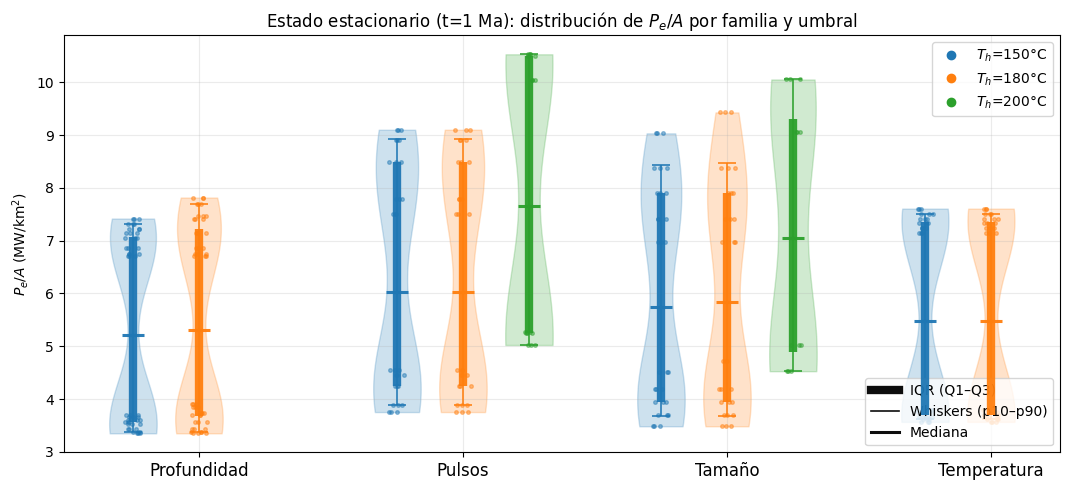

Guardado: outputs_potential/figs_resultados/Fig_steady_PeA_violin_por_familia_y_Th__IQR_whiskers.png


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# --------
# Inputs
# --------
CSV = "outputs_potential/df_all.csv"  # ajustá path si hace falta
OUT = Path("outputs_potential/figs_resultados")
OUT.mkdir(parents=True, exist_ok=True)

OUTPNG = OUT / "Fig_steady_PeA_violin_por_familia_y_Th__IQR_whiskers.png"
OUTPDF = OUT / "Fig_steady_PeA_violin_por_familia_y_Th__IQR_whiskers.pdf"

# --------
# Load
# --------
df = pd.read_csv(CSV)

# normalizar nombre de Pe/A
if "Pe_MW_km2" not in df.columns and "PeA_MW_km2" in df.columns:
    df["Pe_MW_km2"] = df["PeA_MW_km2"]

required = {"family", "Th_C", "L_int_km", "Pe_MW_km2"}
missing = required - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en df_all.csv: {missing}")

# --------
# Config
# --------
order = ["Chamber_Depth", "Chamber_Pulse", "Chamber_Radius", "Chamber_Temp"]
label_map = {
    "Chamber_Depth":  "Profundidad",
    "Chamber_Pulse":  "Pulsos",
    "Chamber_Radius": "Tamaño",
    "Chamber_Temp":   "Temperatura",
}

ONLY_REACH = True  # ponelo en False si querés incluir no-reach (Pe/A ~ 0)

df["family"] = pd.Categorical(df["family"], categories=order, ordered=True)
df = df.sort_values(["family", "Th_C"])

if ONLY_REACH:
    df = df[df["L_int_km"].fillna(0.0) > 0.0].copy()

families = [f for f in order if f in df["family"].astype(str).unique()]
Ths = sorted(df["Th_C"].dropna().unique())

# colores por Th
color_map = {Ths[i]: f"C{i}" for i in range(len(Ths))}

# --------
# Helper: IQR + whiskers + mediana (+ media opcional)
# --------
def add_iqr_whiskers(ax, pos, vals, col, *, whisker_perc=(10, 90),
                     halfwidth_med=0.040, cap=0.035,
                     lw_whisk=1.2, lw_iqr=6.0, lw_med=2.2,
                     alpha=0.95, zorder=6, show_mean=False):
    """
    Dibuja:
      - whiskers: percentiles whisker_perc (default p10-p90)
      - IQR: Q1-Q3 como barra vertical gruesa
      - mediana: línea horizontal
      - (opcional) media: diamante
    """
    vals = np.asarray(vals, dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return

    q1, med, q3 = np.percentile(vals, [25, 50, 75])
    p_lo, p_hi = np.percentile(vals, list(whisker_perc))

    # Whiskers
    ax.vlines(pos, p_lo, p_hi, color=col, linewidth=lw_whisk, alpha=alpha, zorder=zorder-1)
    ax.hlines([p_lo, p_hi], pos-cap, pos+cap, color=col, linewidth=lw_whisk, alpha=alpha, zorder=zorder-1)

    # IQR
    ax.vlines(pos, q1, q3, color=col, linewidth=lw_iqr, alpha=alpha, zorder=zorder)

    # Mediana
    ax.hlines(med, pos-halfwidth_med, pos+halfwidth_med, color=col, linewidth=lw_med, alpha=alpha, zorder=zorder+1)

    # Media opcional
    if show_mean:
        mean = np.mean(vals)
        ax.plot(pos, mean, marker="D", ms=4.5, color=col, alpha=alpha, zorder=zorder+2)

# --------
# Plot (violines)
# --------
x0 = np.arange(len(families))
dx_th = 0.25

fig, ax = plt.subplots(figsize=(10.8, 5.0))
rng = np.random.default_rng(123)  # jitter reproducible

# whiskers como p10–p90 (cambiá a (5,95) si querés)
WHISK = (10, 90)

for j, Th in enumerate(Ths):
    col = color_map[Th]
    for i, fam in enumerate(families):
        vals = df[(df["family"] == fam) & (df["Th_C"] == Th)]["Pe_MW_km2"].dropna().to_numpy(dtype=float)
        if len(vals) == 0:
            continue

        pos = x0[i] + (j - (len(Ths)-1)/2) * dx_th

        # violín (sin mediana interna; la ponemos nosotros)
        vp = ax.violinplot([vals], positions=[pos], widths=0.18,
                           showmedians=False, showextrema=False)
        for body in vp["bodies"]:
            body.set_facecolor(col)
            body.set_edgecolor(col)
            body.set_alpha(0.22)

        # IQR + whiskers + mediana (y media opcional)
        add_iqr_whiskers(ax, pos, vals, col, whisker_perc=WHISK, alpha=0.95, show_mean=False)

        # puntos (jitter)
        xj = pos + (rng.random(len(vals)) - 0.5) * 0.06
        ax.plot(xj, vals, "o", ms=2.6, color=col, alpha=0.45, zorder=2)

ax.set_xticks(x0)
ax.set_xticklabels([label_map.get(f, f) for f in families], fontsize=12)
ax.set_ylabel(r"$P_e/A$ (MW/km$^2$)")
ttl = "Estado estacionario (t=1 Ma): distribución de $P_e/A$ por familia y umbral"
# ttl += " (solo reach)" if ONLY_REACH else " (incluye no-reach)"
ax.set_title(ttl)
ax.grid(True, alpha=0.25)

# leyenda de Th (color) + stats (IQR/whiskers/mediana)
handles_th = [
    Line2D([0],[0], marker="o", linestyle="",
           markerfacecolor=color_map[Th], markeredgecolor=color_map[Th],
           markersize=6, label=fr"$T_h$={int(Th)}°C")
    for Th in Ths
]
handles_stats = [
    Line2D([0],[0], color="k", lw=6, alpha=0.95, label="IQR (Q1–Q3)"),
    Line2D([0],[0], color="k", lw=1.2, alpha=0.95, label=f"Whiskers (p{WHISK[0]}–p{WHISK[1]})"),
    Line2D([0],[0], color="k", lw=2.2, alpha=0.95, label="Mediana"),
]

leg1 = ax.legend(handles=handles_th, loc="upper right", frameon=True)
ax.add_artist(leg1)
ax.legend(handles=handles_stats, loc="lower right", frameon=True, fontsize=10)

fig.tight_layout()
fig.savefig(OUTPNG, dpi=300, bbox_inches="tight")
fig.savefig(OUTPDF, bbox_inches="tight")
plt.show()

print("Guardado:", OUTPNG)
